###Overview

This notebook trains a Mamba model for the UAV class.\
It uses only the samples taken from UAV files (training and validation).\
The model is trained on all sample durations and so we prepare a dataloader that mixes batches of different durations.\
The training class does the training while evaluating the results on the validation samples (of different lengths).\
Notes:
- The training uses an early stopping mechanism where we stop if the validation results have not improved for over "early_stopping" parameter in the configuration.
- The best model parameters are saved, along with the training history. It is possible to load and continue training for a model by configuring 'continued' to True and incrementig 'run' in the training configuration.
- A warm up training with a high learning rate is also implemented.
- Training has an 'evaluation_length' parameter for determining the part of the seuence for which we evaluate performance. I used the last 3 seconds of each sample.
- Since we have different scales between different inputs and different samples, and we want to give them all the same weight in the loss function, we use the 'scale' of the samples to normalize the predictions and lables before going into the loss function. The scale is the 'local Std' calculated for each parameter in preprocessing.
- The model parameters and the time are encoded into a string for the file saving path for identification.

### Imports and loading

In [ ]:
# imports

import io
import os
import sys
from datetime import datetime
from time import time
import pickle
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import copy
import json
import matplotlib.pyplot as plt
import numpy as np
# from scipy.fft import fft
import pandas as pd
import seaborn as sns
import random

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score

# torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
from torch.nn import Sigmoid,ReLU
from torch.nn import Linear,Dropout
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor,Compose
from torch.optim import SparseAdam,Adam,Adagrad,AdamW
from torch.optim.lr_scheduler import LinearLR, MultiStepLR

!pip install einops
# from __future__ import annotations
from dataclasses import dataclass
from einops import rearrange, repeat, einsum

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

from google.colab import drive
drive.mount('/content/drive/')
# helper files
sys.path.append('/content/drive/MyDrive/Final Project UAV/')
from UAV_project_preprocessing_and_visualization_helper_functions_full import *
from mamba_model import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 919.3 kB/s eta 0:00:00
Mounted at /content/drive/
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Final Project UAV/

/content/drive/MyDrive/Final Project UAV


In [ ]:
subfolders = os.listdir("track_data/")
subf_dict = {i:subfolders[i] for i in range(len(subfolders))}
labels_dict = {subfolders[i]:i for i in range(len(subfolders))}

### Model

In [ ]:
def prepare_mixed_dataloader(all_data, batch_size, shuffle = True):
  #shuffled once inside each duration group and then batches are shuffled among durations
  all_batches = []
  for dur, (samples, samples_filenames, dt, scales) in all_data.items():
    dur_vec = [dur]*len(samples)
    if len(samples) > 0:
      data = list(zip(samples, dt, scales, dur_vec))
      dl = DataLoader(data, batch_size = batch_size, shuffle = shuffle)
      for batch in dl:
        all_batches.append(batch)
  if shuffle:
    random.shuffle(all_batches)
  return all_batches

In [ ]:
# save_path = './Samples/mamba_samples_testing0_' + samples_config['subfolder'] + '_all_samples'
# with open(save_path , 'rb') as f:
#   # train_samples, test_samples, train_samples_filenames, test_samples_filenames, train_dt, test_dt, train_scales, test_scales = pickle.load(f)
#   (all_train_data, all_vel_data, all_test_data) = pickle.load(f)

In [ ]:
# train_batches = prepare_mixed_dataloader(all_train_data, 2)
# sample, dt, scale = train_batches[0]

# print(sample.shape)
# print(dt.shape)
# print(scale.shape)

torch.Size([2, 750, 8])
torch.Size([2, 750])
torch.Size([2, 8])


### Training class

In [ ]:
class Training(object):

  def __init__(self, model, config):
    self.config = config
    self.sample_durations = config['sample_durations']
    self.evaluation_durations = config['eval_sample_durations']
    self.device = config['device']
    self.model = model.to(self.config['device'])
    self.model_path = config['model_path']
    lr = config['optimizer_parameter']['lr']
    config['optimizer_parameter']['lr'] = 0.1
    self.optimizer = config['optimizer_type'](model.parameters(), **config['optimizer_parameter'])
    self.scheduler = MultiStepLR(self.optimizer, milestones=[8], gamma=lr/0.1)
    self.criterion = config['criterion'].to(self.device)
    self.epoch_offset = 0
    self.training_time = 0
    self.evaluation_length = int(config['evaluation_time']/config['delta'])

  def train(self, train_data, eval_data):
    self.dl_train = train_data
    self.dl_eval = eval_data
    self.eval_history = {d:[] for d in self.evaluation_durations}
    self.eval_loss_history = []
    self.train_loss_history = []
    self.best_results = {d:None for d in self.evaluation_durations}

    if self.config['continued']:
      self.load_model() #loads model state from a previous run

    epochs_without_improvement = 0
    best_loss = None
    train_start = time()

    for epoch in range(self.epoch_offset, self.config['n_epochs'] + self.epoch_offset):
      # train
      self.train_epoch()
      #evaluate
      self.evaluate_epoch(self.dl_eval)
      self.scheduler.step()
      self.eval_loss_history.append(self.epoch_eval_loss/len(self.dl_eval))
      for d in self.evaluation_durations:
        if len(self.eval_results[d]) > 0: # this in case some class doesn't have test samples that are long enough for this d
          self.eval_history[d].append(sum(self.eval_results[d])/len(self.eval_results[d]))
        else:
          self.eval_history[d].append(0)

      if self.config['verbose']:
        print(f'epoch {epoch}: train loss = {self.train_loss_history[-1]}, eval loss = {self.eval_loss_history[-1]}')
      #check for early stopping
      if not best_loss or self.eval_history[10][-1] < best_loss:
        best_loss = self.eval_history[10][-1]
        best_train_loss = self.train_loss_history[-1]
        best_eval_loss = self.eval_loss_history[-1]
        self.best_results = {d:self.eval_history[d][-1] for d in self.evaluation_durations}

        epochs_without_improvement = 0
        #print ("Achieved lower validation loss, save model at epoch number {} ".format(epoch + 1) )
        best_model = copy.deepcopy(self.model.state_dict())
      else:
        epochs_without_improvement += 1

      if epochs_without_improvement == self.config['early_stopping']:
        if self.config['verbose']:
            print('\nEarly stoping after {} epochs. eval loss did not imporve for more than {} epochs'.format(epoch, self.config['early_stopping']))
        break
    self.training_time = self.training_time + time() - train_start

    # load best model and best performance and save
    self.model.load_state_dict(best_model)
    losslogger = {'train_loss': self.train_loss_history, 'eval_loss': self.eval_loss_history, 'eval_history': self.eval_history}
    state = {'epoch': epoch - epochs_without_improvement + 1, 'state_dict': best_model,
                'optimizer': self.optimizer.state_dict(), 'losslogger': losslogger, 'training_time': self.training_time}
    torch.save(state, self.model_path)

    if self.config['verbose']:
        print('\nFinished Training:')
        print('Best metrics are:')
        print(f'Best loss = {best_loss}')
        print(f'Best train loss = {best_train_loss}')
        print(f'Best eval loss = {best_eval_loss}')
        # print('Evaluation LogLoss = '.format(best_loss))
        for d, best in self.best_results.items():
            print(f'Best {d}sec eval = {best}')

        # print(f'Best 5sec eval = {best_5sec}')
        # print(f'Best 10sec eval= {best_10sec}')
        # print(f'Best 30sec eval= {best_30sec}')
        # print(f'Best 60sec eval= {best_60sec}')

  def train_epoch(self):
    self.epoch_train_loss   = 0
    self.model.train() # train mode
    for batch in tqdm(self.dl_train, disable=(not self.config['verbose'])):
      self.train_batch(batch)
    self.train_loss_history.append(self.epoch_train_loss/len(self.dl_train))


  def train_batch(self, batch):
    data, dt, scale, dur = batch
    # Send tensors to GPU
    samples = data[:,:-1,:]
    labels = data[:,1:,:]
    samples = samples.to(self.device)
    labels = labels.to(self.device)

    dt = dt[:, :-1].to(self.device)
    scale = scale.to(self.device)
    predictions = self.model(samples, dt)#.type(torch.float64)#.type(torch.DoubleTensor)
    scaled_labels = einsum(labels, 1/scale, 'b l d, b d -> b l d')
    scaled_predictions = einsum(predictions, 1/scale, 'b l d, b d -> b l d')
    loss = self.criterion(scaled_predictions, scaled_labels)

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    self.epoch_train_loss += loss.item()

  def evaluate_epoch(self, dl_eval):
    self.eval_results = {d:[] for d in self.evaluation_durations}
    self.epoch_eval_loss = 0

    self.model.eval() #evaluation mode
    with torch.no_grad():
      for batch in tqdm(dl_eval, disable=(not self.config['verbose'])):
        self.eval_batch(batch)

  def eval_batch(self, batch):
    data, dt, scale, dur = batch
    # Send tensors to GPU
    samples = data[:,:-1,:]
    labels = data[:,1:,:]
    samples = samples.to(self.device)
    labels = labels.to(self.device)
    dt = dt[:, :-1].to(self.device)
    scale = scale.to(self.device)

    predictions = self.model(samples, dt)#.type(torch.float64)#.type(torch.DoubleTensor)

    scaled_labels = einsum(labels, 1/scale, 'b l d, b d -> b l d')
    scaled_predictions = einsum(predictions, 1/scale, 'b l d, b d -> b l d')
    criterion = nn.MSELoss(reduction='none').to(self.device)
    eval_loss = criterion(scaled_predictions, scaled_labels)
    self.eval_results[int(dur[0])].append((eval_loss[:, -self.evaluation_length:, :].mean()).cpu())
    self.epoch_eval_loss += eval_loss.mean().item()

  def load_model(self):
    prev_model = self.model_path[:-1] + str(self.config['run']-1)
    if os.path.exists(prev_model) and not os.path.exists(self.model_path):
      state = torch.load(prev_model)
      self.model.load_state_dict(state['state_dict'])
      self.optimizer.load_state_dict(state['optimizer'])
      self.epoch_offset = state['epoch']
      self.train_loss_history = state['losslogger']['train_loss']
      self.eval_loss_history = state['losslogger']['eval_loss']
      self.eval_history = state['losslogger']['eval_history']
      self.training_time = state['training_time']
    else:
      raise ValueError('No previous model found')

In [ ]:
def plot_training_summary(training_model):
  epochs = np.arange(len(training_model.train_loss_history)) + 1
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
  ax1.plot(epochs, training_model.train_loss_history, 'r', label = 'train loss')
  ax1.plot(epochs, training_model.eval_loss_history, 'orange', label = 'eval loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.legend()
  palette = plt.get_cmap('tab20')
  colors = [palette(i) for i in range(len(training_model.evaluation_durations))]
  for d, color in zip(training_model.evaluation_durations, colors):
    plt.yscale("log")
    ax2.plot(epochs, training_model.eval_history[d], color = color, label = d)
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Error')
  ax2.legend()

In [ ]:
def conf2str(mamba_config, training_config):
  #used to encode the run parameters to a string for identification
  conf_str = 'dm' + str(mamba_config['d_model']) \
  +'nl' + str(mamba_config['n_layer']) \
  +'ds' + str(mamba_config['d_state']) \
  +'dc' + str(mamba_config['d_conv']) \
  +'rs' + str(mamba_config['model_random_state']) \
  +'bs' + str(training_config['batch_size']) \
  +'op' + training_config['optimizer_name'] \
  +'lr' + str(training_config['optimizer_parameter']['lr'])\
  +'r' + str(training_config['run'])

  return conf_str

## Experiments
The blocks below execute training.\
We need to:
1. Set the samples configuration
2. Set the Mamba model configuration parameters
3. Create a Mamba model according to the parameters
4. Set the training configuration parameters
5. Init a training instance
6. Prepare dataloaders for the training and validation sets
7. Train
8. Record all the results with the configurations to a pandas dataframe. Save it.
9. Plot the training summary

In [ ]:
samples_config = {
    'subfolder' : 'static-object',
    'delta' : 0.04,
    'sample_durations' : [5, 10, 30, 60],
    'eval_sample_durations' : [5, 10, 15, 20, 25, 30],
    'sample_duration' : 10,
    'skip_duration' : 40,
    'min_samples' : 10
}

In [ ]:
save_path = './Samples/mamba_samples_' + samples_config['subfolder'] + '_skip' + str(samples_config['skip_duration']) +'_split0.2'+ '_all_samples'
with open(save_path , 'rb') as f:
  (all_train_data, all_val_data, all_test_data) = pickle.load(f)

(test_samples, test_filenames, test_dt, test_scales) = all_test_data[5]

In [ ]:
record_columns = ['datetime', 'Best Result @5', 'Best Result @10', 'Best Result @20', 'Learning Rate','Batch Size','Layers','d_state','Model Path', 'Test Files', 'Mamba Config', 'Training Config', 'Train Loss History', 'Evaluation Loss History', 'Eval History', 'Best Results']
exp_record = pd.DataFrame(columns = record_columns)

100%|██████████| 21/21 [00:02<00:00,  9.87it/s]


epoch 0: train loss = 13983462.18939394, eval loss = 6284997.214285715


100%|██████████| 21/21 [00:02<00:00, 10.33it/s]


epoch 1: train loss = 12031126.984848484, eval loss = 5050981.761904762


100%|██████████| 21/21 [00:02<00:00, 10.24it/s]


epoch 2: train loss = 10361738.06439394, eval loss = 4145497.1666666665


100%|██████████| 21/21 [00:02<00:00, 10.07it/s]


epoch 3: train loss = 8982475.102272727, eval loss = 3151464.839285714


100%|██████████| 21/21 [00:02<00:00, 10.16it/s]


epoch 4: train loss = 7701675.507575758, eval loss = 2464375.223214286


100%|██████████| 21/21 [00:02<00:00, 10.01it/s]


epoch 5: train loss = 6643551.240530303, eval loss = 1898917.7797619049


100%|██████████| 21/21 [00:02<00:00, 10.06it/s]


epoch 6: train loss = 5801361.990530303, eval loss = 1499066.8705357143


100%|██████████| 21/21 [00:02<00:00,  9.55it/s]


epoch 7: train loss = 5053318.926136363, eval loss = 1125665.105654762


100%|██████████| 21/21 [00:02<00:00,  8.40it/s]


epoch 8: train loss = 4638785.0539772725, eval loss = 1093301.331845238


100%|██████████| 21/21 [00:02<00:00,  7.57it/s]


epoch 9: train loss = 4574634.876893939, eval loss = 1065416.537202381


100%|██████████| 21/21 [00:02<00:00,  7.49it/s]


epoch 10: train loss = 4522116.194128788, eval loss = 1038513.4523809524


100%|██████████| 21/21 [00:02<00:00,  9.40it/s]


epoch 11: train loss = 4444522.303030303, eval loss = 1011493.0074404762


100%|██████████| 21/21 [00:02<00:00, 10.02it/s]


epoch 12: train loss = 4380230.708333333, eval loss = 983263.0193452381


100%|██████████| 21/21 [00:02<00:00, 10.26it/s]


epoch 13: train loss = 4316516.166666667, eval loss = 955809.6912202381


100%|██████████| 21/21 [00:02<00:00, 10.18it/s]


epoch 14: train loss = 4253882.926136363, eval loss = 929363.099702381


100%|██████████| 21/21 [00:02<00:00, 10.19it/s]


epoch 15: train loss = 4191991.937973485, eval loss = 903584.3779761905


100%|██████████| 21/21 [00:02<00:00, 10.31it/s]


epoch 16: train loss = 4130581.696969697, eval loss = 878358.8489583334


100%|██████████| 21/21 [00:02<00:00, 10.23it/s]


epoch 17: train loss = 4069674.2514204546, eval loss = 853541.068452381


100%|██████████| 21/21 [00:02<00:00, 10.28it/s]


epoch 18: train loss = 4009480.2201704546, eval loss = 829089.6889880953


100%|██████████| 21/21 [00:02<00:00, 10.23it/s]


epoch 19: train loss = 3950037.679450758, eval loss = 805728.5245535715


100%|██████████| 21/21 [00:02<00:00,  9.25it/s]


epoch 20: train loss = 3891319.691998106, eval loss = 783114.4241071428


100%|██████████| 21/21 [00:02<00:00,  8.24it/s]


epoch 21: train loss = 3833389.9713541665, eval loss = 761486.1331845238


100%|██████████| 21/21 [00:02<00:00,  7.40it/s]


epoch 22: train loss = 3776601.5265151514, eval loss = 740311.6904761905


100%|██████████| 21/21 [00:02<00:00,  7.71it/s]


epoch 23: train loss = 3720813.3193655303, eval loss = 720396.8482142857


100%|██████████| 21/21 [00:02<00:00,  9.62it/s]


epoch 24: train loss = 3665486.141808712, eval loss = 701533.9933035715


100%|██████████| 21/21 [00:02<00:00, 10.25it/s]


epoch 25: train loss = 3611208.767282197, eval loss = 683259.8344494047


100%|██████████| 21/21 [00:02<00:00, 10.25it/s]


epoch 26: train loss = 3557928.5030776514, eval loss = 665791.9326636905


100%|██████████| 21/21 [00:02<00:00, 10.19it/s]


epoch 27: train loss = 3505248.731060606, eval loss = 648932.951264881


100%|██████████| 21/21 [00:02<00:00, 10.11it/s]


epoch 28: train loss = 3452700.782907197, eval loss = 632554.591889881


100%|██████████| 21/21 [00:02<00:00, 10.23it/s]


epoch 29: train loss = 3401817.233901515, eval loss = 615965.5305059524


100%|██████████| 21/21 [00:02<00:00, 10.21it/s]


epoch 30: train loss = 3353498.742069129, eval loss = 601111.4226190476


100%|██████████| 21/21 [00:02<00:00,  9.86it/s]


epoch 31: train loss = 3306366.924124053, eval loss = 587688.6923363095


100%|██████████| 21/21 [00:02<00:00,  9.91it/s]


epoch 32: train loss = 3260381.8545217803, eval loss = 573459.9207589285


100%|██████████| 21/21 [00:02<00:00,  8.74it/s]


epoch 33: train loss = 3215619.077888258, eval loss = 561156.6443452381


100%|██████████| 21/21 [00:02<00:00,  7.73it/s]


epoch 34: train loss = 3172312.0484138257, eval loss = 548934.7315848215


100%|██████████| 21/21 [00:02<00:00,  7.29it/s]


epoch 35: train loss = 3129042.0477035986, eval loss = 537849.0444568453


100%|██████████| 21/21 [00:02<00:00,  8.80it/s]


epoch 36: train loss = 3087553.783499053, eval loss = 526786.4246651785


100%|██████████| 21/21 [00:02<00:00,  9.73it/s]


epoch 37: train loss = 3046075.501834754, eval loss = 517244.8472842262


100%|██████████| 21/21 [00:02<00:00, 10.12it/s]


epoch 38: train loss = 3006187.728752367, eval loss = 507798.56305803574


100%|██████████| 21/21 [00:02<00:00, 10.16it/s]


epoch 39: train loss = 2966882.1386126895, eval loss = 499814.36551339284


100%|██████████| 21/21 [00:02<00:00, 10.18it/s]


epoch 40: train loss = 2928955.391867898, eval loss = 491311.94847470237


100%|██████████| 21/21 [00:02<00:00, 10.14it/s]


epoch 41: train loss = 2890526.1168027935, eval loss = 483590.89992559527


100%|██████████| 21/21 [00:02<00:00, 10.14it/s]


epoch 42: train loss = 2852508.500147964, eval loss = 477455.54659598216


100%|██████████| 21/21 [00:02<00:00,  9.86it/s]


epoch 43: train loss = 2817250.3023496685, eval loss = 473126.45172991074


100%|██████████| 21/21 [00:02<00:00,  9.92it/s]


epoch 44: train loss = 2782104.0613606772, eval loss = 465756.90011160716


100%|██████████| 21/21 [00:02<00:00,  9.01it/s]


epoch 45: train loss = 2747499.8098070547, eval loss = 460597.55347842263


100%|██████████| 21/21 [00:02<00:00,  8.06it/s]


epoch 46: train loss = 2713796.042990945, eval loss = 456442.5308779762


100%|██████████| 21/21 [00:03<00:00,  6.92it/s]


epoch 47: train loss = 2682102.537882487, eval loss = 453311.2521391369


100%|██████████| 21/21 [00:02<00:00,  8.05it/s]


epoch 48: train loss = 2650516.8821004233, eval loss = 449490.1370907738


100%|██████████| 21/21 [00:02<00:00, 10.19it/s]


epoch 49: train loss = 2619906.473174124, eval loss = 446424.00251116074


100%|██████████| 21/21 [00:02<00:00, 10.15it/s]


epoch 50: train loss = 2589894.8101880625, eval loss = 442541.5320405506


100%|██████████| 21/21 [00:02<00:00, 10.23it/s]


epoch 51: train loss = 2560471.10900509, eval loss = 438481.7546968006


100%|██████████| 21/21 [00:02<00:00, 10.11it/s]


epoch 52: train loss = 2531285.8138464727, eval loss = 432488.3211030506


100%|██████████| 21/21 [00:02<00:00, 10.26it/s]


epoch 53: train loss = 2502226.5265891333, eval loss = 425925.95186941966


100%|██████████| 21/21 [00:02<00:00,  9.89it/s]


epoch 54: train loss = 2473191.036221591, eval loss = 418952.00906808034


100%|██████████| 21/21 [00:02<00:00, 10.22it/s]


epoch 55: train loss = 2443731.7461825283, eval loss = 414177.0046968006


100%|██████████| 21/21 [00:02<00:00, 10.16it/s]


epoch 56: train loss = 2417446.4319809424, eval loss = 420863.13327752973


100%|██████████| 21/21 [00:02<00:00,  9.69it/s]


epoch 57: train loss = 2393334.18470348, eval loss = 408328.7000558036


100%|██████████| 21/21 [00:02<00:00,  9.03it/s]


epoch 58: train loss = 2360153.26319839, eval loss = 402003.13369605655


100%|██████████| 21/21 [00:02<00:00,  7.83it/s]


epoch 59: train loss = 2327875.687381629, eval loss = 397738.34840029763


100%|██████████| 21/21 [00:02<00:00,  7.04it/s]


epoch 60: train loss = 2297719.4820075757, eval loss = 392418.0533389137


100%|██████████| 21/21 [00:02<00:00,  8.32it/s]


epoch 61: train loss = 2268918.0885416665, eval loss = 389128.8670479911


100%|██████████| 21/21 [00:02<00:00, 10.25it/s]


epoch 62: train loss = 2238989.8785215435, eval loss = 384344.6474144345


100%|██████████| 21/21 [00:02<00:00,  9.92it/s]


epoch 63: train loss = 2209514.046312737, eval loss = 381322.9075520833


100%|██████████| 21/21 [00:02<00:00, 10.26it/s]


epoch 64: train loss = 2181487.3403024385, eval loss = 377759.28538876487


100%|██████████| 21/21 [00:02<00:00, 10.19it/s]


epoch 65: train loss = 2153807.040823272, eval loss = 374517.59444754466


100%|██████████| 21/21 [00:02<00:00, 10.09it/s]


epoch 66: train loss = 2125477.6743164062, eval loss = 370036.81259300595


100%|██████████| 21/21 [00:02<00:00, 10.20it/s]


epoch 67: train loss = 2097832.5158321494, eval loss = 366725.69638206845


100%|██████████| 21/21 [00:02<00:00, 10.21it/s]


epoch 68: train loss = 2069996.1461292615, eval loss = 362128.90634300595


100%|██████████| 21/21 [00:02<00:00, 10.19it/s]


epoch 69: train loss = 2042468.697191643, eval loss = 359343.95042782737


100%|██████████| 21/21 [00:02<00:00,  9.74it/s]


epoch 70: train loss = 2015211.0429243608, eval loss = 357616.73056175595


100%|██████████| 21/21 [00:02<00:00,  8.70it/s]


epoch 71: train loss = 1987502.299523556, eval loss = 352786.72972470237


100%|██████████| 21/21 [00:02<00:00,  7.98it/s]


epoch 72: train loss = 1961124.3748224431, eval loss = 349024.3062686012


100%|██████████| 21/21 [00:03<00:00,  6.93it/s]


epoch 73: train loss = 1934806.2260742188, eval loss = 347110.95126488095


100%|██████████| 21/21 [00:02<00:00,  8.14it/s]


epoch 74: train loss = 1909639.1489257812, eval loss = 346998.8057105655


100%|██████████| 21/21 [00:02<00:00, 10.10it/s]


epoch 75: train loss = 1925201.5785392993, eval loss = 345855.03934151784


100%|██████████| 21/21 [00:02<00:00,  9.88it/s]


epoch 76: train loss = 1877226.994658499, eval loss = 354604.0091145833


100%|██████████| 21/21 [00:02<00:00, 10.19it/s]


epoch 77: train loss = 1845162.6338778408, eval loss = 330513.425827753


100%|██████████| 21/21 [00:02<00:00,  9.83it/s]


epoch 78: train loss = 1813720.771373402, eval loss = 333479.8071754092


100%|██████████| 21/21 [00:02<00:00, 10.18it/s]


epoch 79: train loss = 1787647.7721576113, eval loss = 329514.80192057294


100%|██████████| 21/21 [00:02<00:00, 10.17it/s]


epoch 80: train loss = 1761452.230905244, eval loss = 327843.4417317708


100%|██████████| 21/21 [00:02<00:00, 10.21it/s]


epoch 81: train loss = 1736762.0423546992, eval loss = 328118.216750372


100%|██████████| 21/21 [00:02<00:00, 10.19it/s]


epoch 82: train loss = 1711954.1225437974, eval loss = 325321.47449311754


100%|██████████| 21/21 [00:02<00:00,  9.22it/s]


epoch 83: train loss = 1688139.513671875, eval loss = 318370.7678338914


100%|██████████| 21/21 [00:02<00:00,  8.31it/s]


epoch 84: train loss = 1665020.885616418, eval loss = 312532.1083984375


100%|██████████| 21/21 [00:02<00:00,  7.66it/s]


epoch 85: train loss = 1641752.7660540957, eval loss = 313772.152297247


100%|██████████| 21/21 [00:02<00:00,  7.46it/s]


epoch 86: train loss = 1620458.2071200283, eval loss = 304626.35288783483


100%|██████████| 21/21 [00:02<00:00,  8.90it/s]


epoch 87: train loss = 1595662.1455743962, eval loss = 310893.81110491074


100%|██████████| 21/21 [00:02<00:00, 10.29it/s]


epoch 88: train loss = 1572247.8062263257, eval loss = 306356.84914434527


100%|██████████| 21/21 [00:02<00:00, 10.41it/s]


epoch 89: train loss = 1549157.4611520479, eval loss = 304537.97347005206


100%|██████████| 21/21 [00:02<00:00, 10.49it/s]


epoch 90: train loss = 1525796.4504394531, eval loss = 299079.2579985119


100%|██████████| 21/21 [00:02<00:00, 10.39it/s]


epoch 91: train loss = 1503349.6423265862, eval loss = 294092.6585984003


100%|██████████| 21/21 [00:02<00:00, 10.45it/s]


epoch 92: train loss = 1481201.4764293323, eval loss = 291690.85207403277


100%|██████████| 21/21 [00:02<00:00, 10.48it/s]


epoch 93: train loss = 1459681.8112349077, eval loss = 287126.61007254466


100%|██████████| 21/21 [00:02<00:00, 10.47it/s]


epoch 94: train loss = 1438332.1009632458, eval loss = 283525.8523297991


100%|██████████| 21/21 [00:02<00:00,  9.23it/s]


epoch 95: train loss = 1417399.5290527344, eval loss = 279675.08284505206


100%|██████████| 21/21 [00:02<00:00,  7.61it/s]


epoch 96: train loss = 1396515.5373979048, eval loss = 277940.8125697545


100%|██████████| 21/21 [00:02<00:00,  7.77it/s]


epoch 97: train loss = 1375791.3205048533, eval loss = 274585.70647321426


100%|██████████| 21/21 [00:02<00:00, 10.19it/s]


epoch 98: train loss = 1355171.0123254023, eval loss = 272882.4871186756


100%|██████████| 21/21 [00:02<00:00, 10.29it/s]


epoch 99: train loss = 1334938.4466182825, eval loss = 269645.6377418155


100%|██████████| 21/21 [00:02<00:00, 10.26it/s]


epoch 100: train loss = 1314901.9687573982, eval loss = 266902.85741024924


100%|██████████| 21/21 [00:02<00:00, 10.13it/s]


epoch 101: train loss = 1295186.796730735, eval loss = 262139.38699776787


100%|██████████| 21/21 [00:02<00:00, 10.17it/s]


epoch 102: train loss = 1275613.8800640684, eval loss = 259640.79770042782


100%|██████████| 21/21 [00:02<00:00, 10.34it/s]


epoch 103: train loss = 1256596.605587121, eval loss = 255149.3726515997


100%|██████████| 21/21 [00:02<00:00,  9.44it/s]


epoch 104: train loss = 1237441.4100637725, eval loss = 252167.00158110118


100%|██████████| 21/21 [00:02<00:00,  7.88it/s]


epoch 105: train loss = 1218829.5664950283, eval loss = 245793.840843564


100%|██████████| 21/21 [00:02<00:00,  7.45it/s]


epoch 106: train loss = 1200276.6436730586, eval loss = 244123.67978050595


100%|██████████| 21/21 [00:02<00:00,  9.15it/s]


epoch 107: train loss = 1182170.7216315991, eval loss = 236843.01565987724


100%|██████████| 21/21 [00:02<00:00, 10.22it/s]


epoch 108: train loss = 1164027.0844356653, eval loss = 233777.95839146205


100%|██████████| 21/21 [00:02<00:00, 10.21it/s]


epoch 109: train loss = 1146278.9662346118, eval loss = 228024.85938662576


100%|██████████| 21/21 [00:02<00:00, 10.23it/s]


epoch 110: train loss = 1128583.8271965259, eval loss = 222855.0608142671


100%|██████████| 21/21 [00:02<00:00, 10.07it/s]


epoch 111: train loss = 1111357.364646218, eval loss = 218662.6177455357


100%|██████████| 21/21 [00:02<00:00, 10.28it/s]


epoch 112: train loss = 1094299.0591967034, eval loss = 211607.08777436757


100%|██████████| 21/21 [00:02<00:00,  9.64it/s]


epoch 113: train loss = 1077270.241085168, eval loss = 209929.98130580358


100%|██████████| 21/21 [00:02<00:00,  8.34it/s]


epoch 114: train loss = 1060807.5414891099, eval loss = 200301.45184616814


100%|██████████| 21/21 [00:02<00:00,  7.08it/s]


epoch 115: train loss = 1044210.376805161, eval loss = 207290.9279203869


100%|██████████| 21/21 [00:02<00:00,  8.74it/s]


epoch 116: train loss = 1028854.9785267223, eval loss = 191411.94289434524


100%|██████████| 21/21 [00:02<00:00, 10.27it/s]


epoch 117: train loss = 1013982.7502626361, eval loss = 211866.90864490328


100%|██████████| 21/21 [00:02<00:00, 10.24it/s]


epoch 118: train loss = 1000359.1747270063, eval loss = 184505.34095400857


100%|██████████| 21/21 [00:02<00:00, 10.19it/s]


epoch 119: train loss = 986460.1960671165, eval loss = 188566.91625976562


100%|██████████| 21/21 [00:02<00:00, 10.11it/s]


epoch 120: train loss = 967844.6463844993, eval loss = 182820.725109282


100%|██████████| 21/21 [00:02<00:00, 10.05it/s]


epoch 121: train loss = 952763.9880519058, eval loss = 182915.97665550595


100%|██████████| 21/21 [00:02<00:00, 10.31it/s]


epoch 122: train loss = 936412.3987260298, eval loss = 175314.52757626487


100%|██████████| 21/21 [00:02<00:00,  9.12it/s]


epoch 123: train loss = 921381.5489686908, eval loss = 175354.6053059896


100%|██████████| 21/21 [00:02<00:00,  7.90it/s]


epoch 124: train loss = 906378.4965783322, eval loss = 171215.28780691963


100%|██████████| 21/21 [00:02<00:00,  7.75it/s]


epoch 125: train loss = 891692.7254823627, eval loss = 168975.70877511162


100%|██████████| 21/21 [00:02<00:00, 10.05it/s]


epoch 126: train loss = 877804.5066768762, eval loss = 165577.2188720703


100%|██████████| 21/21 [00:02<00:00, 10.25it/s]


epoch 127: train loss = 862994.6918612394, eval loss = 162608.20473516555


100%|██████████| 21/21 [00:02<00:00, 10.18it/s]


epoch 128: train loss = 849381.3745542584, eval loss = 159480.16972423735


100%|██████████| 21/21 [00:02<00:00, 10.16it/s]


epoch 129: train loss = 834499.5775849314, eval loss = 156505.3494466146


100%|██████████| 21/21 [00:02<00:00,  9.95it/s]


epoch 130: train loss = 821250.9610207297, eval loss = 155853.52850051154


100%|██████████| 21/21 [00:02<00:00, 10.31it/s]


epoch 131: train loss = 810157.0379231771, eval loss = 155186.20854259672


100%|██████████| 21/21 [00:02<00:00,  9.45it/s]


epoch 132: train loss = 796822.0562078302, eval loss = 150084.23315429688


100%|██████████| 21/21 [00:02<00:00,  8.05it/s]


epoch 133: train loss = 782492.6816831647, eval loss = 150527.74515206474


100%|██████████| 21/21 [00:02<00:00,  7.07it/s]


epoch 134: train loss = 771256.6111968069, eval loss = 146834.68289620537


100%|██████████| 21/21 [00:02<00:00,  9.00it/s]


epoch 135: train loss = 757448.7472719135, eval loss = 148835.88494001116


100%|██████████| 21/21 [00:02<00:00, 10.14it/s]


epoch 136: train loss = 746200.2228670988, eval loss = 219545.17331659226


100%|██████████| 21/21 [00:02<00:00, 10.22it/s]


epoch 137: train loss = 730587.2316265684, eval loss = 155418.33390299478


100%|██████████| 21/21 [00:02<00:00,  9.02it/s]


epoch 138: train loss = 724010.3426865087, eval loss = 148792.68622116814


100%|██████████| 21/21 [00:02<00:00, 10.22it/s]


epoch 139: train loss = 707661.0816391454, eval loss = 137032.99232700892


100%|██████████| 21/21 [00:02<00:00, 10.22it/s]


epoch 140: train loss = 699602.5657589075, eval loss = 146601.8448311942


100%|██████████| 21/21 [00:02<00:00, 10.17it/s]


epoch 141: train loss = 684134.7583932588, eval loss = 133157.38230096726


100%|██████████| 21/21 [00:02<00:00,  8.89it/s]


epoch 142: train loss = 674197.3152040424, eval loss = 229398.52573939733


100%|██████████| 21/21 [00:02<00:00,  7.44it/s]


epoch 143: train loss = 702923.9466034861, eval loss = 223357.6134672619


100%|██████████| 21/21 [00:02<00:00,  8.03it/s]


epoch 144: train loss = 870500.3445194128, eval loss = 234069.62397693453


100%|██████████| 21/21 [00:02<00:00, 10.11it/s]


epoch 145: train loss = 725408.3480113636, eval loss = 144403.56101190476


100%|██████████| 21/21 [00:02<00:00, 10.00it/s]


epoch 146: train loss = 659187.1771129261, eval loss = 212947.60035342263


100%|██████████| 21/21 [00:02<00:00, 10.28it/s]


epoch 147: train loss = 656982.8996656013, eval loss = 147046.53427269345


100%|██████████| 21/21 [00:02<00:00,  9.99it/s]


epoch 148: train loss = 626877.3328598485, eval loss = 244118.99660528274


100%|██████████| 21/21 [00:02<00:00, 10.02it/s]


epoch 149: train loss = 626457.8814216383, eval loss = 136244.45498511905


100%|██████████| 21/21 [00:02<00:00, 10.14it/s]


epoch 150: train loss = 599983.8074840199, eval loss = 207653.7214936756


100%|██████████| 21/21 [00:02<00:00,  9.56it/s]


epoch 151: train loss = 597611.4674479166, eval loss = 134057.5726841518


100%|██████████| 21/21 [00:02<00:00,  8.26it/s]


epoch 152: train loss = 577641.8746522845, eval loss = 165669.36067708334


100%|██████████| 21/21 [00:02<00:00,  7.10it/s]


epoch 153: train loss = 570946.1117054332, eval loss = 145094.4779575893


100%|██████████| 21/21 [00:02<00:00,  8.51it/s]


epoch 154: train loss = 557874.5915083452, eval loss = 147827.04296875


100%|██████████| 21/21 [00:02<00:00, 10.14it/s]


epoch 155: train loss = 547870.326097893, eval loss = 144885.89490327382


100%|██████████| 21/21 [00:02<00:00, 10.18it/s]


epoch 156: train loss = 537356.2719060724, eval loss = 144964.5164388021


100%|██████████| 21/21 [00:02<00:00, 10.21it/s]


epoch 157: train loss = 527324.2953361742, eval loss = 137995.54878162203


100%|██████████| 21/21 [00:02<00:00, 10.15it/s]


epoch 158: train loss = 516921.5246729995, eval loss = 135672.04164341517


100%|██████████| 21/21 [00:02<00:00, 10.22it/s]


epoch 159: train loss = 507716.01511452417, eval loss = 124787.23039899554


100%|██████████| 21/21 [00:02<00:00, 10.21it/s]


epoch 160: train loss = 497263.03284801135, eval loss = 128693.3957170759


100%|██████████| 21/21 [00:02<00:00,  9.04it/s]


epoch 161: train loss = 489528.4873860677, eval loss = 119096.93429129464


100%|██████████| 21/21 [00:02<00:00,  7.79it/s]


epoch 162: train loss = 478917.61396188446, eval loss = 122736.77857607887


100%|██████████| 21/21 [00:02<00:00,  7.94it/s]


epoch 163: train loss = 470310.7471220999, eval loss = 122460.98637462797


100%|██████████| 21/21 [00:02<00:00, 10.11it/s]


epoch 164: train loss = 460575.92047674005, eval loss = 114873.16443452382


100%|██████████| 21/21 [00:02<00:00, 10.09it/s]


epoch 165: train loss = 450756.4152166193, eval loss = 106195.63278924851


100%|██████████| 21/21 [00:02<00:00, 10.23it/s]


epoch 166: train loss = 446695.2275760535, eval loss = 121226.49348958333


100%|██████████| 21/21 [00:02<00:00, 10.15it/s]


epoch 167: train loss = 440616.39183090674, eval loss = 101316.31852213542


100%|██████████| 21/21 [00:02<00:00, 10.23it/s]


epoch 168: train loss = 424985.257553563, eval loss = 98093.47093563988


100%|██████████| 21/21 [00:02<00:00,  9.98it/s]


epoch 169: train loss = 418021.83140980115, eval loss = 96543.11426943824


100%|██████████| 21/21 [00:02<00:00,  9.42it/s]


epoch 170: train loss = 410656.4738769531, eval loss = 99947.95856584821


100%|██████████| 21/21 [00:02<00:00,  8.18it/s]


epoch 171: train loss = 400088.1647727273, eval loss = 91981.11723400297


100%|██████████| 21/21 [00:03<00:00,  6.96it/s]


epoch 172: train loss = 391276.8690814394, eval loss = 88105.3140578497


100%|██████████| 21/21 [00:02<00:00,  8.91it/s]


epoch 173: train loss = 385682.20719401044, eval loss = 88087.63892764137


100%|██████████| 21/21 [00:02<00:00, 10.16it/s]


epoch 174: train loss = 375562.8388412938, eval loss = 88040.52655319941


100%|██████████| 21/21 [00:02<00:00,  9.85it/s]


epoch 175: train loss = 367492.08272668085, eval loss = 83397.47943405878


100%|██████████| 21/21 [00:02<00:00, 10.15it/s]


epoch 176: train loss = 360180.2498224432, eval loss = 82825.06821986607


100%|██████████| 21/21 [00:02<00:00, 10.21it/s]


epoch 177: train loss = 356070.0089148319, eval loss = 81149.14769345238


100%|██████████| 21/21 [00:02<00:00, 10.20it/s]


epoch 178: train loss = 343894.75940681226, eval loss = 78817.92812383742


100%|██████████| 21/21 [00:02<00:00,  9.56it/s]


epoch 179: train loss = 336439.7441147313, eval loss = 77311.49596005394


100%|██████████| 21/21 [00:02<00:00,  8.26it/s]


epoch 180: train loss = 329481.6052209103, eval loss = 76466.75653366816


100%|██████████| 21/21 [00:02<00:00,  7.20it/s]


epoch 181: train loss = 324889.44885623816, eval loss = 76111.42556036086


100%|██████████| 21/21 [00:02<00:00,  8.87it/s]


epoch 182: train loss = 317488.85385594226, eval loss = 74422.86633882069


100%|██████████| 21/21 [00:02<00:00,  9.97it/s]


epoch 183: train loss = 309387.92216722894, eval loss = 73174.7308233352


100%|██████████| 21/21 [00:02<00:00, 10.19it/s]


epoch 184: train loss = 302337.20376124524, eval loss = 71696.77216448102


100%|██████████| 21/21 [00:02<00:00, 10.20it/s]


epoch 185: train loss = 296409.8009883996, eval loss = 70719.36232793899


100%|██████████| 21/21 [00:02<00:00, 10.18it/s]


epoch 186: train loss = 290700.7185613459, eval loss = 69861.16564360118


100%|██████████| 21/21 [00:02<00:00, 10.14it/s]


epoch 187: train loss = 288338.867446437, eval loss = 69058.15752883184


100%|██████████| 21/21 [00:02<00:00, 10.15it/s]


epoch 188: train loss = 276138.04241018585, eval loss = 67629.95726957775


100%|██████████| 21/21 [00:02<00:00,  8.37it/s]


epoch 189: train loss = 270055.7517570727, eval loss = 66202.70144507999


100%|██████████| 21/21 [00:02<00:00,  7.03it/s]


epoch 190: train loss = 264480.95322117663, eval loss = 65518.852213541664


100%|██████████| 21/21 [00:02<00:00,  8.58it/s]


epoch 191: train loss = 261090.64005533853, eval loss = 64512.58927408854


100%|██████████| 21/21 [00:02<00:00, 10.22it/s]


epoch 192: train loss = 252027.42633241595, eval loss = 63766.59295944941


100%|██████████| 21/21 [00:02<00:00, 10.19it/s]


epoch 193: train loss = 247079.51726740057, eval loss = 63190.763427734375


100%|██████████| 21/21 [00:02<00:00, 10.10it/s]


epoch 194: train loss = 334759.847323331, eval loss = 80329.28999255953


100%|██████████| 21/21 [00:02<00:00, 10.13it/s]


epoch 195: train loss = 267240.83127663354, eval loss = 92598.2275390625


100%|██████████| 21/21 [00:02<00:00, 10.06it/s]


epoch 196: train loss = 263860.61755741003, eval loss = 87875.85616629464


100%|██████████| 21/21 [00:02<00:00,  9.84it/s]


epoch 197: train loss = 249284.40963837595, eval loss = 94942.05571056547


100%|██████████| 21/21 [00:02<00:00,  8.24it/s]


epoch 198: train loss = 244569.984448982, eval loss = 68913.03025018601


100%|██████████| 21/21 [00:03<00:00,  6.97it/s]


epoch 199: train loss = 235573.27510949338, eval loss = 73085.79117838542


100%|██████████| 21/21 [00:02<00:00,  8.56it/s]


epoch 200: train loss = 224062.3985262784, eval loss = 67103.23746744792


100%|██████████| 21/21 [00:02<00:00, 10.09it/s]


epoch 201: train loss = 213894.4238577178, eval loss = 64925.040201822914


100%|██████████| 21/21 [00:02<00:00, 10.12it/s]


epoch 202: train loss = 206771.44399562027, eval loss = 64908.60925874256


100%|██████████| 21/21 [00:02<00:00, 10.12it/s]


epoch 203: train loss = 200707.05842359137, eval loss = 68227.7339797247


100%|██████████| 21/21 [00:02<00:00, 10.18it/s]


epoch 204: train loss = 195175.5643939394, eval loss = 74167.52334449405


100%|██████████| 21/21 [00:02<00:00, 10.02it/s]


epoch 205: train loss = 190390.70385002368, eval loss = 72995.95073009672


100%|██████████| 21/21 [00:02<00:00,  9.37it/s]


epoch 206: train loss = 186728.03214518228, eval loss = 75548.74181547618


100%|██████████| 21/21 [00:02<00:00,  7.94it/s]


epoch 207: train loss = 187208.98168205493, eval loss = 69905.45024181547


100%|██████████| 21/21 [00:02<00:00,  7.44it/s]


epoch 208: train loss = 179821.0137310606, eval loss = 62309.69426618303


100%|██████████| 21/21 [00:02<00:00,  9.73it/s]


epoch 209: train loss = 170089.13332297586, eval loss = 53383.85258556547


100%|██████████| 21/21 [00:02<00:00, 10.15it/s]


epoch 210: train loss = 164883.0341205019, eval loss = 64938.28050595238


100%|██████████| 21/21 [00:02<00:00, 10.10it/s]


epoch 211: train loss = 161673.68317945075, eval loss = 54362.35256231399


100%|██████████| 21/21 [00:02<00:00, 10.09it/s]


epoch 212: train loss = 160318.3386748343, eval loss = 85534.67859468007


100%|██████████| 21/21 [00:02<00:00,  9.87it/s]


epoch 213: train loss = 169707.22486091382, eval loss = 51177.41213262649


100%|██████████| 21/21 [00:02<00:00, 10.20it/s]


epoch 214: train loss = 157494.8221768466, eval loss = 76795.23539806547


100%|██████████| 21/21 [00:02<00:00,  9.29it/s]


epoch 215: train loss = 159835.5252648556, eval loss = 49580.540132068454


100%|██████████| 21/21 [00:02<00:00,  7.95it/s]


epoch 216: train loss = 145746.41182824338, eval loss = 49104.31975446428


100%|██████████| 21/21 [00:02<00:00,  7.54it/s]


epoch 217: train loss = 138051.7803252249, eval loss = 66720.60522460938


100%|██████████| 21/21 [00:02<00:00, 10.08it/s]


epoch 218: train loss = 135011.236328125, eval loss = 51016.923618861605


100%|██████████| 21/21 [00:02<00:00,  9.92it/s]


epoch 219: train loss = 132327.50829338306, eval loss = 60095.01606677828


100%|██████████| 21/21 [00:02<00:00,  9.91it/s]


epoch 220: train loss = 134007.43019797586, eval loss = 52869.59588913691


100%|██████████| 21/21 [00:02<00:00, 10.18it/s]


epoch 221: train loss = 128721.92036206795, eval loss = 71619.76850818453


100%|██████████| 21/21 [00:02<00:00, 10.13it/s]


epoch 222: train loss = 133679.36681758997, eval loss = 55028.17371186756


100%|██████████| 21/21 [00:02<00:00, 10.05it/s]


epoch 223: train loss = 124477.62821821733, eval loss = 56152.43992978051


100%|██████████| 21/21 [00:02<00:00,  9.05it/s]


epoch 224: train loss = 121182.00378787878, eval loss = 81471.73223586309


100%|██████████| 21/21 [00:02<00:00,  7.40it/s]


epoch 225: train loss = 124233.14369895241, eval loss = 66278.08823939732


100%|██████████| 21/21 [00:02<00:00,  7.72it/s]


epoch 226: train loss = 111272.29016483191, eval loss = 63222.13119652158


100%|██████████| 21/21 [00:02<00:00, 10.05it/s]


epoch 227: train loss = 105960.9521928267, eval loss = 62888.97213890439


100%|██████████| 21/21 [00:02<00:00, 10.06it/s]


epoch 228: train loss = 103598.1210419626, eval loss = 60154.89216541109


100%|██████████| 21/21 [00:02<00:00, 10.08it/s]


epoch 229: train loss = 100890.70980927438, eval loss = 78979.33322288876


100%|██████████| 21/21 [00:02<00:00, 10.00it/s]


epoch 230: train loss = 104933.94397342566, eval loss = 46235.39829799107


100%|██████████| 21/21 [00:02<00:00, 10.05it/s]


epoch 231: train loss = 100160.04816968513, eval loss = 76944.32814825149


100%|██████████| 21/21 [00:02<00:00, 10.13it/s]


epoch 232: train loss = 95227.82067871094, eval loss = 55464.11672828311


100%|██████████| 21/21 [00:02<00:00,  9.03it/s]


epoch 233: train loss = 89683.81891054095, eval loss = 105094.41697474888


100%|██████████| 21/21 [00:02<00:00,  7.77it/s]


epoch 234: train loss = 92209.75618119673, eval loss = 52666.46826171875


100%|██████████| 21/21 [00:02<00:00,  7.72it/s]


epoch 235: train loss = 85414.47303355824, eval loss = 65236.89768182664


100%|██████████| 21/21 [00:02<00:00, 10.17it/s]


epoch 236: train loss = 84816.33942205255, eval loss = 53424.340425037204


100%|██████████| 21/21 [00:02<00:00, 10.08it/s]


epoch 237: train loss = 81829.05338541667, eval loss = 96978.15358770461


100%|██████████| 21/21 [00:02<00:00, 10.08it/s]


epoch 238: train loss = 86101.9237948331, eval loss = 41320.850306919645


100%|██████████| 21/21 [00:02<00:00,  9.99it/s]


epoch 239: train loss = 78064.75550056226, eval loss = 72829.67886207218


100%|██████████| 21/21 [00:02<00:00,  9.72it/s]


epoch 240: train loss = 74269.08511999881, eval loss = 65864.91163853237


100%|██████████| 21/21 [00:02<00:00, 10.03it/s]


epoch 241: train loss = 73353.13169167259, eval loss = 148894.4794747489


100%|██████████| 21/21 [00:02<00:00,  8.67it/s]


epoch 242: train loss = 78171.2353959517, eval loss = 76505.22742280507


100%|██████████| 21/21 [00:02<00:00,  7.20it/s]


epoch 243: train loss = 76820.28102065578, eval loss = 132630.410609654


100%|██████████| 21/21 [00:02<00:00,  8.22it/s]


epoch 244: train loss = 70858.45257753314, eval loss = 37951.80580357143


100%|██████████| 21/21 [00:02<00:00, 10.05it/s]


epoch 245: train loss = 65638.0370908795, eval loss = 52401.04176548549


100%|██████████| 21/21 [00:02<00:00, 10.16it/s]


epoch 246: train loss = 61866.44153941761, eval loss = 59493.0194905599


100%|██████████| 21/21 [00:02<00:00, 10.13it/s]


epoch 247: train loss = 65021.74729225852, eval loss = 69695.77833775112


100%|██████████| 21/21 [00:02<00:00, 10.09it/s]


epoch 248: train loss = 63477.74698893229, eval loss = 57890.660475957964


100%|██████████| 21/21 [00:02<00:00, 10.13it/s]


epoch 249: train loss = 147934.0371315696, eval loss = 61033.48688616072


100%|██████████| 21/21 [00:02<00:00, 10.10it/s]


epoch 250: train loss = 80034.59542939157, eval loss = 242430.76131184897


100%|██████████| 21/21 [00:02<00:00,  9.29it/s]


epoch 251: train loss = 86729.10145892519, eval loss = 133253.07964797248


100%|██████████| 21/21 [00:02<00:00,  7.90it/s]


epoch 252: train loss = 66862.69522002249, eval loss = 26844.90847051711


100%|██████████| 21/21 [00:02<00:00,  7.64it/s]


epoch 253: train loss = 59434.374822443184, eval loss = 34701.64500790551


100%|██████████| 21/21 [00:02<00:00, 10.01it/s]


epoch 254: train loss = 52227.62749319366, eval loss = 38961.61032249814


100%|██████████| 21/21 [00:02<00:00, 10.15it/s]


epoch 255: train loss = 51688.81754187382, eval loss = 42736.90369814918


100%|██████████| 21/21 [00:02<00:00, 10.06it/s]


epoch 256: train loss = 51035.53834487453, eval loss = 44351.577619280135


100%|██████████| 21/21 [00:02<00:00, 10.02it/s]


epoch 257: train loss = 47878.95085745147, eval loss = 46492.54245140439


100%|██████████| 21/21 [00:02<00:00, 10.09it/s]


epoch 258: train loss = 47221.43300559304, eval loss = 46179.98914155506


100%|██████████| 21/21 [00:02<00:00, 10.11it/s]


epoch 259: train loss = 44856.56291429924, eval loss = 48553.301589239214


100%|██████████| 21/21 [00:02<00:00,  9.23it/s]


epoch 260: train loss = 43267.594830137314, eval loss = 49378.19530087426


100%|██████████| 21/21 [00:02<00:00,  7.79it/s]


epoch 261: train loss = 42650.26751893939, eval loss = 46913.908150809155


100%|██████████| 21/21 [00:02<00:00,  7.78it/s]


epoch 262: train loss = 47491.04270241477, eval loss = 52062.21342540922


100%|██████████| 21/21 [00:02<00:00,  9.85it/s]


epoch 263: train loss = 42057.35311612216, eval loss = 47427.15366327195


100%|██████████| 21/21 [00:02<00:00, 10.06it/s]


epoch 264: train loss = 38433.817834102745, eval loss = 48901.46995907738


100%|██████████| 21/21 [00:02<00:00,  9.64it/s]


epoch 265: train loss = 36240.06126819958, eval loss = 48175.15076264881


100%|██████████| 21/21 [00:02<00:00, 10.04it/s]


epoch 266: train loss = 35305.282171075996, eval loss = 51851.52915736607


100%|██████████| 21/21 [00:02<00:00, 10.03it/s]


epoch 267: train loss = 34068.970973159325, eval loss = 46704.70062546503


100%|██████████| 21/21 [00:02<00:00, 10.12it/s]


epoch 268: train loss = 34073.0361439098, eval loss = 63461.38231259301


100%|██████████| 21/21 [00:02<00:00,  8.70it/s]


epoch 269: train loss = 33399.41265684186, eval loss = 43929.46707007998


100%|██████████| 21/21 [00:02<00:00,  7.03it/s]


epoch 270: train loss = 32606.59940962358, eval loss = 79505.57571847098


100%|██████████| 21/21 [00:02<00:00,  8.49it/s]


epoch 271: train loss = 32379.69298576586, eval loss = 63054.41045851934


100%|██████████| 21/21 [00:02<00:00, 10.00it/s]


epoch 272: train loss = 31580.488580877132, eval loss = 60494.763235909595


100%|██████████| 21/21 [00:02<00:00, 10.00it/s]


epoch 273: train loss = 33242.06660230232, eval loss = 60083.025559198286


100%|██████████| 21/21 [00:02<00:00, 10.09it/s]


epoch 274: train loss = 31060.32742217093, eval loss = 49202.753173828125


100%|██████████| 21/21 [00:02<00:00, 10.06it/s]


epoch 275: train loss = 28014.942016601562, eval loss = 48416.82181222098


100%|██████████| 21/21 [00:02<00:00,  9.96it/s]


epoch 276: train loss = 25291.045498934658, eval loss = 47167.70507231213


100%|██████████| 21/21 [00:02<00:00,  9.99it/s]


epoch 277: train loss = 23918.143606474907, eval loss = 47415.33521670387


100%|██████████| 21/21 [00:02<00:00,  8.48it/s]


epoch 278: train loss = 26200.450317382812, eval loss = 52722.27918643043


100%|██████████| 21/21 [00:02<00:00,  7.11it/s]


epoch 279: train loss = 27011.85664876302, eval loss = 44755.33231608073


100%|██████████| 21/21 [00:02<00:00,  8.72it/s]


epoch 280: train loss = 27471.833514589252, eval loss = 79663.51854887462


100%|██████████| 21/21 [00:02<00:00, 10.07it/s]


epoch 281: train loss = 29963.753980232006, eval loss = 33918.31204659598


100%|██████████| 21/21 [00:02<00:00,  9.94it/s]


epoch 282: train loss = 25217.639737215908, eval loss = 92866.25558617001


100%|██████████| 21/21 [00:02<00:00, 10.10it/s]


epoch 283: train loss = 26250.49130341501, eval loss = 69062.55648949032


100%|██████████| 21/21 [00:02<00:00, 10.03it/s]


epoch 284: train loss = 24341.905824603455, eval loss = 80398.51243954613


100%|██████████| 21/21 [00:02<00:00, 10.04it/s]


epoch 285: train loss = 25191.133580063328, eval loss = 106982.92924572172


100%|██████████| 21/21 [00:02<00:00,  9.71it/s]


epoch 286: train loss = 43463.76881362453, eval loss = 70679.34349423363


100%|██████████| 21/21 [00:02<00:00,  8.17it/s]


epoch 287: train loss = 38463.8915756688, eval loss = 75227.94704473586


100%|██████████| 21/21 [00:03<00:00,  6.84it/s]


epoch 288: train loss = 28113.417635830967, eval loss = 71131.0607968285


100%|██████████| 21/21 [00:02<00:00,  9.06it/s]


epoch 289: train loss = 24684.995710893112, eval loss = 78707.37190755208


100%|██████████| 21/21 [00:02<00:00,  9.93it/s]


epoch 290: train loss = 22643.187638716263, eval loss = 59558.99925595238


100%|██████████| 21/21 [00:02<00:00,  9.97it/s]


epoch 291: train loss = 18683.636076956085, eval loss = 65721.10767473493


100%|██████████| 21/21 [00:02<00:00, 10.10it/s]


epoch 292: train loss = 16681.137221827652, eval loss = 71991.38421921503


100%|██████████| 21/21 [00:02<00:00, 10.10it/s]


epoch 293: train loss = 15333.789682099314, eval loss = 77460.67935616629


100%|██████████| 21/21 [00:02<00:00, 10.07it/s]


epoch 294: train loss = 15147.193093039772, eval loss = 78730.30638485863


100%|██████████| 21/21 [00:02<00:00,  9.43it/s]


epoch 295: train loss = 15864.745890299479, eval loss = 61836.67472912016


100%|██████████| 21/21 [00:02<00:00,  7.97it/s]


epoch 296: train loss = 15851.697546756628, eval loss = 61586.65480840774


100%|██████████| 21/21 [00:02<00:00,  7.31it/s]


epoch 297: train loss = 15581.602982954546, eval loss = 70821.50930931454


100%|██████████| 21/21 [00:02<00:00,  9.90it/s]


epoch 298: train loss = 16689.919566761364, eval loss = 104872.78351120722


100%|██████████| 21/21 [00:02<00:00,  9.91it/s]


epoch 299: train loss = 14497.145883271189, eval loss = 37878.96078055246


100%|██████████| 21/21 [00:02<00:00, 10.08it/s]


epoch 300: train loss = 13000.2612323183, eval loss = 72040.11315336681


100%|██████████| 21/21 [00:02<00:00, 10.05it/s]


epoch 301: train loss = 17986.736550071022, eval loss = 46683.57937476748


100%|██████████| 21/21 [00:02<00:00, 10.02it/s]


epoch 302: train loss = 18900.273455995502, eval loss = 30037.042573474704


100%|██████████| 21/21 [00:02<00:00, 10.06it/s]


epoch 303: train loss = 19285.97101754853, eval loss = 107994.52839587984


100%|██████████| 21/21 [00:02<00:00,  8.99it/s]


epoch 304: train loss = 16258.812107895359, eval loss = 48944.73034667969


100%|██████████| 21/21 [00:02<00:00,  7.76it/s]


epoch 305: train loss = 14504.62344637784, eval loss = 70882.75135439918


100%|██████████| 21/21 [00:02<00:00,  7.96it/s]


epoch 306: train loss = 11696.119323730469, eval loss = 63122.78478422619


100%|██████████| 21/21 [00:02<00:00,  9.82it/s]


epoch 307: train loss = 10850.668407093395, eval loss = 81540.64428710938


100%|██████████| 21/21 [00:02<00:00, 10.00it/s]


epoch 308: train loss = 10500.864030317827, eval loss = 71207.00960867746


100%|██████████| 21/21 [00:02<00:00,  9.87it/s]


epoch 309: train loss = 10844.367714621803, eval loss = 59018.69054594494


100%|██████████| 21/21 [00:02<00:00, 10.05it/s]


epoch 310: train loss = 9884.370089444246, eval loss = 62430.48880440848


100%|██████████| 21/21 [00:02<00:00,  9.91it/s]


epoch 311: train loss = 8796.108600038471, eval loss = 68028.3754766555


100%|██████████| 21/21 [00:02<00:00,  9.78it/s]


epoch 312: train loss = 8229.59922836766, eval loss = 59456.65800548735


100%|██████████| 21/21 [00:02<00:00,  8.36it/s]


epoch 313: train loss = 7729.81474905303, eval loss = 68237.26161993117


100%|██████████| 21/21 [00:03<00:00,  6.95it/s]


epoch 314: train loss = 8054.34247750947, eval loss = 61626.635498046875


100%|██████████| 21/21 [00:02<00:00,  8.64it/s]


epoch 315: train loss = 8613.973077947443, eval loss = 67053.67825753348


100%|██████████| 21/21 [00:02<00:00,  9.73it/s]


epoch 316: train loss = 9684.49042672822, eval loss = 35535.14944893973


100%|██████████| 21/21 [00:02<00:00,  9.85it/s]


epoch 317: train loss = 10282.458947383997, eval loss = 40445.73631649926


100%|██████████| 21/21 [00:02<00:00, 10.02it/s]


epoch 318: train loss = 8479.30800374349, eval loss = 103684.1804547991


100%|██████████| 21/21 [00:02<00:00,  9.99it/s]


epoch 319: train loss = 10454.500954367897, eval loss = 33240.08312406994


100%|██████████| 21/21 [00:02<00:00,  9.87it/s]


epoch 320: train loss = 10353.861424301609, eval loss = 50332.71308244978


100%|██████████| 21/21 [00:02<00:00,  9.38it/s]


epoch 321: train loss = 9385.32607384884, eval loss = 46771.752982003345


100%|██████████| 21/21 [00:02<00:00,  7.84it/s]


epoch 322: train loss = 8401.378447561554, eval loss = 35070.41705031622


100%|██████████| 21/21 [00:02<00:00,  7.44it/s]


epoch 323: train loss = 9691.494575269295, eval loss = 34184.78604561942


100%|██████████| 21/21 [00:02<00:00, 10.11it/s]


epoch 324: train loss = 8666.152783942945, eval loss = 58582.665132068454


100%|██████████| 21/21 [00:02<00:00,  9.79it/s]


epoch 325: train loss = 8313.652876420454, eval loss = 46040.24639020647


100%|██████████| 21/21 [00:02<00:00, 10.00it/s]


epoch 326: train loss = 7670.5919855291195, eval loss = 45383.690563383556


100%|██████████| 21/21 [00:02<00:00, 10.06it/s]


epoch 327: train loss = 6904.497445771189, eval loss = 40915.58390880766


100%|██████████| 21/21 [00:02<00:00, 10.12it/s]


epoch 328: train loss = 6544.823366107363, eval loss = 41063.215349469865


100%|██████████| 21/21 [00:02<00:00,  9.72it/s]


epoch 329: train loss = 7036.6807565400095, eval loss = 32959.107293991816


100%|██████████| 21/21 [00:02<00:00,  8.48it/s]


epoch 330: train loss = 7344.278843735204, eval loss = 49633.775518508184


100%|██████████| 21/21 [00:02<00:00,  7.08it/s]


epoch 331: train loss = 8278.046016808712, eval loss = 50038.74019949777


100%|██████████| 21/21 [00:02<00:00,  8.72it/s]


epoch 332: train loss = 9967.161963260534, eval loss = 34620.216634114586


100%|██████████| 21/21 [00:02<00:00,  9.87it/s]


epoch 333: train loss = 7994.2404452237215, eval loss = 35012.648082914806


100%|██████████| 21/21 [00:02<00:00,  9.85it/s]


epoch 334: train loss = 7182.024746981534, eval loss = 52107.11226981027


100%|██████████| 21/21 [00:02<00:00, 10.02it/s]


epoch 335: train loss = 6001.04569868608, eval loss = 31404.63772437686


100%|██████████| 21/21 [00:02<00:00,  9.98it/s]


epoch 336: train loss = 6998.15791459517, eval loss = 29615.99017624628


100%|██████████| 21/21 [00:02<00:00,  9.98it/s]


epoch 337: train loss = 7269.66113466205, eval loss = 45765.72291782924


100%|██████████| 21/21 [00:02<00:00,  9.36it/s]


epoch 338: train loss = 8779.727589000355, eval loss = 43738.785807291664


100%|██████████| 21/21 [00:02<00:00,  7.85it/s]


epoch 339: train loss = 7664.6626087535515, eval loss = 52371.519069126676


100%|██████████| 21/21 [00:02<00:00,  7.14it/s]


epoch 340: train loss = 8553.724770285866, eval loss = 33121.91371372768


100%|██████████| 21/21 [00:02<00:00, 10.05it/s]


epoch 341: train loss = 7969.7451578776045, eval loss = 42853.43385532924


100%|██████████| 21/21 [00:02<00:00, 10.05it/s]


epoch 342: train loss = 6267.9879076408615, eval loss = 45826.15670921689


100%|██████████| 21/21 [00:02<00:00, 10.06it/s]


epoch 343: train loss = 12123.492392800072, eval loss = 24571.503278459822


100%|██████████| 21/21 [00:02<00:00,  9.93it/s]


epoch 344: train loss = 9121.780297481653, eval loss = 41245.51371837797


100%|██████████| 21/21 [00:02<00:00,  9.99it/s]


epoch 345: train loss = 8429.401013923414, eval loss = 69696.48736281622


100%|██████████| 21/21 [00:02<00:00, 10.01it/s]


epoch 346: train loss = 8630.284978693182, eval loss = 50795.255318777905


100%|██████████| 21/21 [00:02<00:00,  8.93it/s]


epoch 347: train loss = 6562.778475674716, eval loss = 26573.39904203869


100%|██████████| 21/21 [00:02<00:00,  7.18it/s]


epoch 348: train loss = 6068.855392918442, eval loss = 78060.7355608259


100%|██████████| 21/21 [00:02<00:00,  8.44it/s]


epoch 349: train loss = 6095.4979987866955, eval loss = 28819.441830589658


100%|██████████| 21/21 [00:02<00:00,  9.97it/s]


epoch 350: train loss = 5786.624474727746, eval loss = 30735.269292922247


100%|██████████| 21/21 [00:02<00:00,  9.88it/s]


epoch 351: train loss = 4659.726458925189, eval loss = 51345.22420247396


100%|██████████| 21/21 [00:02<00:00,  9.86it/s]


epoch 352: train loss = 5178.81943396366, eval loss = 22812.89630998884


100%|██████████| 21/21 [00:02<00:00, 10.01it/s]


epoch 353: train loss = 5623.391621907552, eval loss = 56606.86673409598


100%|██████████| 21/21 [00:02<00:00,  9.99it/s]


epoch 354: train loss = 7688.007183652936, eval loss = 30149.371965680803


100%|██████████| 21/21 [00:02<00:00,  9.25it/s]


epoch 355: train loss = 12064.11367890329, eval loss = 36651.009713309155


100%|██████████| 21/21 [00:02<00:00,  7.76it/s]


epoch 356: train loss = 8707.492316968513, eval loss = 46313.07057989211


100%|██████████| 21/21 [00:02<00:00,  7.62it/s]


epoch 357: train loss = 6327.560570919152, eval loss = 59482.98505510603


100%|██████████| 21/21 [00:02<00:00,  9.99it/s]


epoch 358: train loss = 7325.722188313802, eval loss = 34227.46904645647


100%|██████████| 21/21 [00:02<00:00,  9.87it/s]


epoch 359: train loss = 11745.650675455729, eval loss = 32703.938459123885


100%|██████████| 21/21 [00:02<00:00,  9.84it/s]


epoch 360: train loss = 6920.414689497514, eval loss = 49714.20983886719


100%|██████████| 21/21 [00:02<00:00, 10.12it/s]


epoch 361: train loss = 7013.393628669508, eval loss = 41219.29865373884


100%|██████████| 21/21 [00:02<00:00, 10.06it/s]


epoch 362: train loss = 5922.756660230232, eval loss = 45787.60678245908


100%|██████████| 21/21 [00:02<00:00, 10.00it/s]


epoch 363: train loss = 4869.755654074929, eval loss = 46977.76077706473


100%|██████████| 21/21 [00:02<00:00,  8.18it/s]


epoch 364: train loss = 4788.615894664417, eval loss = 38540.87245396205


100%|██████████| 21/21 [00:03<00:00,  6.83it/s]


epoch 365: train loss = 4618.233481667258, eval loss = 39764.777512323286


100%|██████████| 21/21 [00:02<00:00,  8.61it/s]


epoch 366: train loss = 4558.2866247928505, eval loss = 40051.39093889509


100%|██████████| 21/21 [00:02<00:00, 10.03it/s]


epoch 367: train loss = 4603.99590324633, eval loss = 37289.02385021391


100%|██████████| 21/21 [00:02<00:00,  9.98it/s]


epoch 368: train loss = 4772.4185273141575, eval loss = 36294.75834728422


100%|██████████| 21/21 [00:02<00:00,  9.78it/s]


epoch 369: train loss = 4946.77431603634, eval loss = 38124.85618373326


100%|██████████| 21/21 [00:02<00:00, 10.01it/s]


epoch 370: train loss = 5046.5412190755205, eval loss = 37171.99611700149


100%|██████████| 21/21 [00:02<00:00, 10.03it/s]


epoch 371: train loss = 4921.3003410570545, eval loss = 37436.4805733817


100%|██████████| 21/21 [00:02<00:00,  9.22it/s]


epoch 372: train loss = 4668.3433911872635, eval loss = 36759.122122628345


100%|██████████| 21/21 [00:02<00:00,  7.83it/s]


epoch 373: train loss = 4502.752448804451, eval loss = 36741.35482933408


100%|██████████| 21/21 [00:02<00:00,  7.42it/s]


epoch 374: train loss = 4485.642763080019, eval loss = 35691.87816801525


100%|██████████| 21/21 [00:02<00:00, 10.04it/s]


epoch 375: train loss = 4621.141246448864, eval loss = 35315.538254510786


100%|██████████| 21/21 [00:02<00:00,  9.93it/s]


epoch 376: train loss = 4852.145722360322, eval loss = 33594.85452125186


100%|██████████| 21/21 [00:02<00:00,  9.99it/s]


epoch 377: train loss = 4863.930795380564, eval loss = 32626.53510393415


100%|██████████| 21/21 [00:02<00:00,  9.67it/s]


epoch 378: train loss = 5098.4347663648205, eval loss = 33598.85913667225


100%|██████████| 21/21 [00:02<00:00, 10.07it/s]


epoch 379: train loss = 5567.91259765625, eval loss = 35148.85959007627


100%|██████████| 21/21 [00:02<00:00, 10.04it/s]


epoch 380: train loss = 5329.280719179095, eval loss = 36464.96528552828


100%|██████████| 21/21 [00:02<00:00,  8.48it/s]


epoch 381: train loss = 5340.7142777876425, eval loss = 32849.936540876115


100%|██████████| 21/21 [00:02<00:00,  7.15it/s]


epoch 382: train loss = 5510.019877115886, eval loss = 30947.64611235119


100%|██████████| 21/21 [00:02<00:00,  8.34it/s]


epoch 383: train loss = 4809.211261171283, eval loss = 36462.85643368676


100%|██████████| 21/21 [00:02<00:00, 10.02it/s]


epoch 384: train loss = 4686.529420794863, eval loss = 36996.66208031064


100%|██████████| 21/21 [00:02<00:00,  9.74it/s]


epoch 385: train loss = 4975.6449418501425, eval loss = 32665.16909644717


100%|██████████| 21/21 [00:02<00:00,  9.91it/s]


epoch 386: train loss = 8164.8988111091385, eval loss = 38316.723016648066


100%|██████████| 21/21 [00:02<00:00,  9.97it/s]


epoch 387: train loss = 13747.300857081558, eval loss = 481263.9592982701


100%|██████████| 21/21 [00:02<00:00, 10.01it/s]


epoch 388: train loss = 166413.91874556107, eval loss = 1575381.05796596


100%|██████████| 21/21 [00:02<00:00,  9.12it/s]


epoch 389: train loss = 119525.2538988518, eval loss = 41827.98443312872


100%|██████████| 21/21 [00:02<00:00,  7.78it/s]


epoch 390: train loss = 54175.201053503784, eval loss = 33725.76892089844


100%|██████████| 21/21 [00:02<00:00,  7.27it/s]


epoch 391: train loss = 97996.0019235322, eval loss = 37794.114839099704


100%|██████████| 21/21 [00:02<00:00, 10.00it/s]


epoch 392: train loss = 73986.89783824574, eval loss = 31142.142485119046


100%|██████████| 21/21 [00:02<00:00,  9.99it/s]


epoch 393: train loss = 68698.41544596355, eval loss = 39524.02106584822


100%|██████████| 21/21 [00:02<00:00,  9.87it/s]


epoch 394: train loss = 41128.63234271425, eval loss = 20008.816266741072


100%|██████████| 21/21 [00:02<00:00,  9.89it/s]


epoch 395: train loss = 22014.821555397728, eval loss = 22278.489943731398


100%|██████████| 21/21 [00:02<00:00,  9.91it/s]


epoch 396: train loss = 17212.81484153054, eval loss = 23871.424740745908


100%|██████████| 21/21 [00:02<00:00, 10.00it/s]


epoch 397: train loss = 16744.298968690815, eval loss = 25211.26921735491


100%|██████████| 21/21 [00:02<00:00,  8.27it/s]


epoch 398: train loss = 12872.958102139559, eval loss = 24989.44258626302


100%|██████████| 21/21 [00:03<00:00,  6.85it/s]


epoch 399: train loss = 13419.834916548296, eval loss = 27461.93155343192


100%|██████████| 21/21 [00:02<00:00,  8.62it/s]


epoch 400: train loss = 9244.216785777699, eval loss = 25842.111037481398


100%|██████████| 21/21 [00:02<00:00, 10.02it/s]


epoch 401: train loss = 7938.113734389796, eval loss = 25797.823381696428


100%|██████████| 21/21 [00:02<00:00, 10.02it/s]


epoch 402: train loss = 6911.0074240944605, eval loss = 24475.58711751302


100%|██████████| 21/21 [00:02<00:00,  9.93it/s]


epoch 403: train loss = 7142.3329079367895, eval loss = 24646.619338262648


100%|██████████| 21/21 [00:02<00:00,  9.59it/s]


epoch 404: train loss = 6676.7521639737215, eval loss = 24508.759672619046


100%|██████████| 21/21 [00:02<00:00,  9.95it/s]


epoch 405: train loss = 8562.915734493372, eval loss = 24913.92727515811


100%|██████████| 21/21 [00:02<00:00,  8.65it/s]


epoch 406: train loss = 6262.443535082268, eval loss = 22714.139293852306


100%|██████████| 21/21 [00:03<00:00,  6.91it/s]


epoch 407: train loss = 5429.42256303267, eval loss = 22292.233555385046


100%|██████████| 21/21 [00:02<00:00,  8.41it/s]


epoch 408: train loss = 5364.559897682883, eval loss = 22262.898239862352


100%|██████████| 21/21 [00:02<00:00,  9.94it/s]


epoch 409: train loss = 5089.803725733902, eval loss = 21380.634887695312


100%|██████████| 21/21 [00:02<00:00,  9.80it/s]


epoch 410: train loss = 4914.985035289417, eval loss = 21138.61110723586


100%|██████████| 21/21 [00:02<00:00,  9.88it/s]


epoch 411: train loss = 4720.380776145242, eval loss = 20373.18287876674


100%|██████████| 21/21 [00:02<00:00,  9.83it/s]


epoch 412: train loss = 4619.7145071318655, eval loss = 20274.065080915178


100%|██████████| 21/21 [00:02<00:00,  9.99it/s]


epoch 413: train loss = 4496.212034283262, eval loss = 19729.31272088914


100%|██████████| 21/21 [00:02<00:00,  9.05it/s]


epoch 414: train loss = 4459.319755785393, eval loss = 19697.44002859933


100%|██████████| 21/21 [00:02<00:00,  7.39it/s]


epoch 415: train loss = 4372.550357703007, eval loss = 19268.62500581287


100%|██████████| 21/21 [00:02<00:00,  8.19it/s]


epoch 416: train loss = 4348.0102945963545, eval loss = 19306.60362606957


100%|██████████| 21/21 [00:02<00:00,  9.89it/s]


epoch 417: train loss = 4282.589386911103, eval loss = 18953.67104957217


100%|██████████| 21/21 [00:02<00:00,  9.81it/s]


epoch 418: train loss = 4266.222271543561, eval loss = 19032.049362909227


100%|██████████| 21/21 [00:02<00:00,  9.96it/s]


epoch 419: train loss = 4211.135777328954, eval loss = 18684.23020717076


100%|██████████| 21/21 [00:02<00:00, 10.05it/s]


epoch 420: train loss = 4200.929095643939, eval loss = 18806.86658877418


100%|██████████| 21/21 [00:02<00:00,  9.73it/s]


epoch 421: train loss = 4149.836298162287, eval loss = 18414.121680850076


100%|██████████| 21/21 [00:02<00:00,  8.94it/s]


epoch 422: train loss = 4138.519420276989, eval loss = 18573.879667736233


100%|██████████| 21/21 [00:02<00:00,  7.56it/s]


epoch 423: train loss = 4122.753094297467, eval loss = 18301.131190708704


100%|██████████| 21/21 [00:02<00:00,  7.54it/s]


epoch 424: train loss = 4586.0721065636835, eval loss = 18031.70824032738


100%|██████████| 21/21 [00:02<00:00,  9.99it/s]


epoch 425: train loss = 4783.069661458333, eval loss = 17643.587158203125


100%|██████████| 21/21 [00:02<00:00,  9.94it/s]


epoch 426: train loss = 4665.720065030185, eval loss = 18430.907929920017


100%|██████████| 21/21 [00:02<00:00,  9.70it/s]


epoch 427: train loss = 4570.703211928859, eval loss = 17869.429106212796


100%|██████████| 21/21 [00:02<00:00,  9.94it/s]


epoch 428: train loss = 4676.9589436848955, eval loss = 18486.5040515718


100%|██████████| 21/21 [00:02<00:00,  9.88it/s]


epoch 429: train loss = 4944.2139078776045, eval loss = 18531.98279389881


100%|██████████| 21/21 [00:02<00:00,  9.38it/s]


epoch 430: train loss = 5105.341758034446, eval loss = 18889.29006812686


100%|██████████| 21/21 [00:02<00:00,  8.16it/s]


epoch 431: train loss = 5005.9478241891575, eval loss = 18612.894368489582


100%|██████████| 21/21 [00:03<00:00,  6.94it/s]


epoch 432: train loss = 4812.460562041311, eval loss = 18992.924240838915


100%|██████████| 21/21 [00:02<00:00,  8.98it/s]


epoch 433: train loss = 4598.663034150095, eval loss = 18708.388323102678


100%|██████████| 21/21 [00:02<00:00, 10.00it/s]


epoch 434: train loss = 4387.914639559659, eval loss = 18375.684663318454


100%|██████████| 21/21 [00:02<00:00,  9.95it/s]


epoch 435: train loss = 4266.571061567826, eval loss = 18455.57930501302


100%|██████████| 21/21 [00:02<00:00,  9.99it/s]


epoch 436: train loss = 4244.626681241122, eval loss = 18469.99121675037


100%|██████████| 21/21 [00:02<00:00,  9.79it/s]


epoch 437: train loss = 4198.667737556227, eval loss = 18126.772414434523


100%|██████████| 21/21 [00:02<00:00,  9.91it/s]


epoch 438: train loss = 4200.707134824811, eval loss = 18537.167282831102


100%|██████████| 21/21 [00:02<00:00,  8.24it/s]


epoch 439: train loss = 4279.0111453894415, eval loss = 18214.082304454983


100%|██████████| 21/21 [00:03<00:00,  6.97it/s]


epoch 440: train loss = 4407.939351399739, eval loss = 18935.397646949405


100%|██████████| 21/21 [00:02<00:00,  9.19it/s]


epoch 441: train loss = 4599.064334753788, eval loss = 19010.638538178944


100%|██████████| 21/21 [00:02<00:00,  9.96it/s]


epoch 442: train loss = 7375.370494495739, eval loss = 18529.46533203125


100%|██████████| 21/21 [00:02<00:00,  9.79it/s]


epoch 443: train loss = 11504.919888583097, eval loss = 15661.428588867188


100%|██████████| 21/21 [00:02<00:00,  9.97it/s]


epoch 444: train loss = 7627.939695416075, eval loss = 23049.47731817336


100%|██████████| 21/21 [00:02<00:00,  9.96it/s]


epoch 445: train loss = 9410.79307047526, eval loss = 21757.330240885418


100%|██████████| 21/21 [00:02<00:00,  9.76it/s]


epoch 446: train loss = 12149.960301254734, eval loss = 15280.801449730283


100%|██████████| 21/21 [00:02<00:00,  8.00it/s]


epoch 447: train loss = 32616.550699869793, eval loss = 18133.306722005207


100%|██████████| 21/21 [00:03<00:00,  6.92it/s]


epoch 448: train loss = 43013.28350645123, eval loss = 133455.62289574032


100%|██████████| 21/21 [00:02<00:00,  8.97it/s]


epoch 449: train loss = 146512.86985085226, eval loss = 58045.49376860119


100%|██████████| 21/21 [00:02<00:00,  9.87it/s]


epoch 450: train loss = 68437.15534741951, eval loss = 47722.38197544643


100%|██████████| 21/21 [00:02<00:00,  9.94it/s]


epoch 451: train loss = 50148.10316790956, eval loss = 21143.480422247023


100%|██████████| 21/21 [00:02<00:00,  9.93it/s]


epoch 452: train loss = 30864.420968720406, eval loss = 28899.169270833332


100%|██████████| 21/21 [00:02<00:00,  9.87it/s]


epoch 453: train loss = 22703.098188920456, eval loss = 24512.06322079613


100%|██████████| 21/21 [00:02<00:00,  9.96it/s]


epoch 454: train loss = 18734.71171801018, eval loss = 24524.46257672991


100%|██████████| 21/21 [00:02<00:00,  8.70it/s]


epoch 455: train loss = 17899.521906072445, eval loss = 23120.826218377977


100%|██████████| 21/21 [00:03<00:00,  6.98it/s]


epoch 456: train loss = 17159.171730735085, eval loss = 22537.91385323661


100%|██████████| 21/21 [00:02<00:00,  8.37it/s]


epoch 457: train loss = 16094.454245827415, eval loss = 22390.49083891369


100%|██████████| 21/21 [00:02<00:00,  9.94it/s]


epoch 458: train loss = 15259.304180723248, eval loss = 22412.00689406622


100%|██████████| 21/21 [00:02<00:00,  9.89it/s]


epoch 459: train loss = 14923.842007723722, eval loss = 21405.277215866816


100%|██████████| 21/21 [00:02<00:00,  9.85it/s]


epoch 460: train loss = 13591.473858457623, eval loss = 20406.264357793898


100%|██████████| 21/21 [00:02<00:00,  9.94it/s]


epoch 461: train loss = 12162.372229373816, eval loss = 20082.514683314734


100%|██████████| 21/21 [00:02<00:00,  9.88it/s]


epoch 462: train loss = 11290.795476740057, eval loss = 20169.088928222656


100%|██████████| 21/21 [00:02<00:00,  8.01it/s]


epoch 463: train loss = 11249.71649909742, eval loss = 18727.167236328125


100%|██████████| 21/21 [00:03<00:00,  6.97it/s]


epoch 464: train loss = 9572.617768258759, eval loss = 18729.764020647322


100%|██████████| 21/21 [00:02<00:00,  8.41it/s]


epoch 465: train loss = 9704.10479181463, eval loss = 19274.460205078125


100%|██████████| 21/21 [00:02<00:00,  9.95it/s]


epoch 466: train loss = 14117.145768599077, eval loss = 17572.484648204983


100%|██████████| 21/21 [00:02<00:00,  9.87it/s]


epoch 467: train loss = 8655.037248091265, eval loss = 16964.94444638207


100%|██████████| 21/21 [00:02<00:00,  9.88it/s]


epoch 468: train loss = 7791.853450890743, eval loss = 17090.37531389509


100%|██████████| 21/21 [00:02<00:00,  9.95it/s]


epoch 469: train loss = 7438.5665135239105, eval loss = 17082.005077543712


100%|██████████| 21/21 [00:02<00:00,  9.90it/s]


epoch 470: train loss = 9267.067414254852, eval loss = 17357.356526692707


100%|██████████| 21/21 [00:02<00:00,  8.20it/s]


epoch 471: train loss = 13294.552014899977, eval loss = 17895.492030552454


100%|██████████| 21/21 [00:03<00:00,  6.80it/s]


epoch 472: train loss = 7916.5901729699335, eval loss = 16206.58346702939


100%|██████████| 21/21 [00:02<00:00,  8.87it/s]


epoch 473: train loss = 6566.119584517045, eval loss = 16337.398492722285


100%|██████████| 21/21 [00:02<00:00,  9.85it/s]


epoch 474: train loss = 6295.948976458925, eval loss = 16424.41818963914


100%|██████████| 21/21 [00:02<00:00,  9.73it/s]


epoch 475: train loss = 6130.279524369674, eval loss = 16224.706502278646


100%|██████████| 21/21 [00:02<00:00,  9.63it/s]


epoch 476: train loss = 5780.433111017401, eval loss = 16368.494995117188


100%|██████████| 21/21 [00:02<00:00,  9.95it/s]


epoch 477: train loss = 5676.4311412464485, eval loss = 16379.588303338915


100%|██████████| 21/21 [00:02<00:00,  9.88it/s]


epoch 478: train loss = 5480.7331949869795, eval loss = 16618.919913155692


100%|██████████| 21/21 [00:02<00:00,  8.18it/s]


epoch 479: train loss = 5312.7367165305395, eval loss = 16733.402018229168


100%|██████████| 21/21 [00:03<00:00,  6.94it/s]


epoch 480: train loss = 5215.782820268111, eval loss = 16770.35555594308


100%|██████████| 21/21 [00:02<00:00,  8.57it/s]


epoch 481: train loss = 4959.148750073982, eval loss = 17290.880330403645


100%|██████████| 21/21 [00:02<00:00,  9.85it/s]


epoch 482: train loss = 5058.081326571378, eval loss = 17657.35598609561


100%|██████████| 21/21 [00:02<00:00,  9.79it/s]


epoch 483: train loss = 7941.3506118312025, eval loss = 16613.50402250744


100%|██████████| 21/21 [00:02<00:00,  9.81it/s]


epoch 484: train loss = 6010.9621766986265, eval loss = 17347.1883312407


100%|██████████| 21/21 [00:02<00:00,  9.79it/s]


epoch 485: train loss = 5595.074719978102, eval loss = 18987.568705240887


100%|██████████| 21/21 [00:02<00:00,  9.92it/s]


epoch 486: train loss = 7208.719328909209, eval loss = 17225.831551688058


100%|██████████| 21/21 [00:02<00:00,  8.24it/s]


epoch 487: train loss = 5280.340000961766, eval loss = 24952.48869105748


100%|██████████| 21/21 [00:02<00:00,  7.00it/s]


epoch 488: train loss = 6975.7951327237215, eval loss = 16596.402442568826


100%|██████████| 21/21 [00:02<00:00,  9.24it/s]


epoch 489: train loss = 4808.746557987098, eval loss = 18861.08214750744


100%|██████████| 21/21 [00:02<00:00,  9.91it/s]


epoch 490: train loss = 5220.019359241833, eval loss = 26074.079287574405


100%|██████████| 21/21 [00:02<00:00,  9.90it/s]


epoch 491: train loss = 4523.287927800959, eval loss = 129202.91491408575


100%|██████████| 21/21 [00:02<00:00,  9.85it/s]


epoch 492: train loss = 11846.044089577415, eval loss = 18472.88108607701


100%|██████████| 21/21 [00:02<00:00, 10.00it/s]


epoch 493: train loss = 7719.8361483487215, eval loss = 27275.66058640253


100%|██████████| 21/21 [00:02<00:00,  9.94it/s]


epoch 494: train loss = 10409.332759972775, eval loss = 26664.0784883045


100%|██████████| 21/21 [00:02<00:00,  8.23it/s]


epoch 495: train loss = 8835.578570741596, eval loss = 21658.042061941964


100%|██████████| 21/21 [00:03<00:00,  6.88it/s]


epoch 496: train loss = 9889.001736727629, eval loss = 21199.954613095237


100%|██████████| 21/21 [00:02<00:00,  9.04it/s]


epoch 497: train loss = 7013.9174786192, eval loss = 21137.468351818265


100%|██████████| 21/21 [00:02<00:00,  9.95it/s]


epoch 498: train loss = 6466.8581210049715, eval loss = 20653.30158342634


100%|██████████| 21/21 [00:02<00:00,  9.85it/s]


epoch 499: train loss = 6258.4543124112215, eval loss = 20164.705531529016


100%|██████████| 21/21 [00:02<00:00,  9.90it/s]


epoch 500: train loss = 6035.9661051432295, eval loss = 19689.814650762648


100%|██████████| 21/21 [00:02<00:00,  9.81it/s]


epoch 501: train loss = 5854.2794189453125, eval loss = 19332.599028087796


100%|██████████| 21/21 [00:02<00:00,  9.18it/s]


epoch 502: train loss = 5671.04364753492, eval loss = 18910.215491885232


100%|██████████| 21/21 [00:02<00:00,  7.76it/s]


epoch 503: train loss = 5497.854677142519, eval loss = 18484.368123372395


100%|██████████| 21/21 [00:02<00:00,  7.04it/s]


epoch 504: train loss = 5310.944242535215, eval loss = 18091.896809895832


100%|██████████| 21/21 [00:02<00:00,  9.52it/s]


epoch 505: train loss = 5133.693426883582, eval loss = 17758.92215401786


100%|██████████| 21/21 [00:02<00:00,  9.81it/s]


epoch 506: train loss = 4976.91128170129, eval loss = 17387.97807094029


100%|██████████| 21/21 [00:02<00:00,  9.86it/s]


epoch 507: train loss = 4834.005645751953, eval loss = 17163.688188825334


100%|██████████| 21/21 [00:02<00:00,  9.64it/s]


epoch 508: train loss = 4686.0062847715435, eval loss = 16688.946995326452


100%|██████████| 21/21 [00:02<00:00,  9.70it/s]


epoch 509: train loss = 4543.114493630149, eval loss = 16435.00671096075


100%|██████████| 21/21 [00:02<00:00,  8.99it/s]


epoch 510: train loss = 4409.062810724432, eval loss = 15864.124720982143


100%|██████████| 21/21 [00:02<00:00,  7.57it/s]


epoch 511: train loss = 4286.397127093691, eval loss = 15689.094360351562


100%|██████████| 21/21 [00:02<00:00,  7.67it/s]


epoch 512: train loss = 4193.411347360322, eval loss = 15253.271740141368


100%|██████████| 21/21 [00:02<00:00,  9.73it/s]


epoch 513: train loss = 4163.768593528054, eval loss = 16463.433901832217


100%|██████████| 21/21 [00:02<00:00,  9.86it/s]


epoch 514: train loss = 5114.397558038885, eval loss = 15355.44225202288


100%|██████████| 21/21 [00:02<00:00,  9.81it/s]


epoch 515: train loss = 4137.248521284623, eval loss = 15033.487409319196


100%|██████████| 21/21 [00:02<00:00,  9.58it/s]


epoch 516: train loss = 4235.096507679333, eval loss = 14162.463120233446


100%|██████████| 21/21 [00:02<00:00,  9.88it/s]


epoch 517: train loss = 4038.0447165749288, eval loss = 14682.381001790365


100%|██████████| 21/21 [00:02<00:00,  8.91it/s]


epoch 518: train loss = 4478.826600045869, eval loss = 13023.558991931734


100%|██████████| 21/21 [00:02<00:00,  7.25it/s]


epoch 519: train loss = 4527.707052519827, eval loss = 15023.88809640067


100%|██████████| 21/21 [00:02<00:00,  8.11it/s]


epoch 520: train loss = 4917.089732776989, eval loss = 12685.590985979352


100%|██████████| 21/21 [00:02<00:00,  9.90it/s]


epoch 521: train loss = 4298.553434429747, eval loss = 18784.76682826451


100%|██████████| 21/21 [00:02<00:00,  9.83it/s]


epoch 522: train loss = 6596.549003832268, eval loss = 14341.262023925781


100%|██████████| 21/21 [00:02<00:00,  9.91it/s]


epoch 523: train loss = 5838.453234123461, eval loss = 28300.852867489768


100%|██████████| 21/21 [00:02<00:00,  9.87it/s]


epoch 524: train loss = 10057.103523023201, eval loss = 20119.47641136533


100%|██████████| 21/21 [00:02<00:00,  9.88it/s]


epoch 525: train loss = 9181.036153157553, eval loss = 30615.86790248326


100%|██████████| 21/21 [00:02<00:00,  8.86it/s]


epoch 526: train loss = 21447.602298620975, eval loss = 17030.692283993674


100%|██████████| 21/21 [00:02<00:00,  7.00it/s]


epoch 527: train loss = 8319.556559244791, eval loss = 36601.726507277715


100%|██████████| 21/21 [00:02<00:00,  8.40it/s]


epoch 528: train loss = 5519.504233620383, eval loss = 15958.320164271763


100%|██████████| 21/21 [00:02<00:00,  9.54it/s]


epoch 529: train loss = 4163.8213371508045, eval loss = 18746.200276692707


100%|██████████| 21/21 [00:02<00:00,  9.98it/s]


epoch 530: train loss = 4369.8079538056345, eval loss = 16507.67775472005


100%|██████████| 21/21 [00:02<00:00,  9.85it/s]


epoch 531: train loss = 3955.3345114968038, eval loss = 14785.307695661273


100%|██████████| 21/21 [00:02<00:00,  9.84it/s]


epoch 532: train loss = 3664.8536265980115, eval loss = 14260.48379952567


100%|██████████| 21/21 [00:02<00:00,  9.79it/s]


epoch 533: train loss = 3672.4236376213303, eval loss = 14347.761625744048


100%|██████████| 21/21 [00:02<00:00,  8.70it/s]


epoch 534: train loss = 3597.858191287879, eval loss = 13354.607907249814


100%|██████████| 21/21 [00:03<00:00,  6.90it/s]


epoch 535: train loss = 3514.634207060843, eval loss = 13619.967878069196


100%|██████████| 21/21 [00:02<00:00,  8.64it/s]


epoch 536: train loss = 3543.5319787227745, eval loss = 13079.614307221913


100%|██████████| 21/21 [00:02<00:00,  9.81it/s]


epoch 537: train loss = 3473.6572543057528, eval loss = 13435.447402227492


100%|██████████| 21/21 [00:02<00:00,  9.78it/s]


epoch 538: train loss = 3533.0875410600142, eval loss = 12729.679094587054


100%|██████████| 21/21 [00:02<00:00,  9.71it/s]


epoch 539: train loss = 3433.2376838452888, eval loss = 13571.114034016928


100%|██████████| 21/21 [00:02<00:00,  9.91it/s]


epoch 540: train loss = 3597.6846849846115, eval loss = 12504.60256812686


100%|██████████| 21/21 [00:02<00:00,  9.86it/s]


epoch 541: train loss = 3412.4773041696258, eval loss = 14445.617824009487


100%|██████████| 21/21 [00:02<00:00,  8.04it/s]


epoch 542: train loss = 3895.2038185813212, eval loss = 12912.473098028273


100%|██████████| 21/21 [00:02<00:00,  7.01it/s]


epoch 543: train loss = 3670.722303910689, eval loss = 18838.278477260046


100%|██████████| 21/21 [00:02<00:00,  8.42it/s]


epoch 544: train loss = 5500.322822339607, eval loss = 14298.248976934523


100%|██████████| 21/21 [00:02<00:00,  9.87it/s]


epoch 545: train loss = 4718.700682668975, eval loss = 29396.803315662204


100%|██████████| 21/21 [00:02<00:00,  9.96it/s]


epoch 546: train loss = 9898.215659401634, eval loss = 14451.815554664248


100%|██████████| 21/21 [00:02<00:00,  9.69it/s]


epoch 547: train loss = 11853.34179502545, eval loss = 17906.05744280134


100%|██████████| 21/21 [00:02<00:00,  9.76it/s]


epoch 548: train loss = 10814.566922274504, eval loss = 14734.46318272182


100%|██████████| 21/21 [00:02<00:00,  9.56it/s]


epoch 549: train loss = 7946.878682454427, eval loss = 14302.649977911085


100%|██████████| 21/21 [00:02<00:00,  8.09it/s]


epoch 550: train loss = 4948.600756096117, eval loss = 14193.37415422712


100%|██████████| 21/21 [00:03<00:00,  6.83it/s]


epoch 551: train loss = 4817.21967754942, eval loss = 13370.93803187779


100%|██████████| 21/21 [00:02<00:00,  8.75it/s]


epoch 552: train loss = 3834.041163589015, eval loss = 18269.491251627605


100%|██████████| 21/21 [00:02<00:00,  9.78it/s]


epoch 553: train loss = 4912.844214237098, eval loss = 14683.279479980469


100%|██████████| 21/21 [00:02<00:00,  9.76it/s]


epoch 554: train loss = 4274.035859079072, eval loss = 33057.15321277437


100%|██████████| 21/21 [00:02<00:00,  9.63it/s]


epoch 555: train loss = 7515.646277225379, eval loss = 12904.799766903832


100%|██████████| 21/21 [00:02<00:00,  9.53it/s]


epoch 556: train loss = 5377.8163137724905, eval loss = 18796.738461449033


100%|██████████| 21/21 [00:02<00:00,  9.84it/s]


epoch 557: train loss = 3877.591415867661, eval loss = 15197.881193615141


100%|██████████| 21/21 [00:02<00:00,  7.94it/s]


epoch 558: train loss = 3971.2977313417377, eval loss = 12662.972260974702


100%|██████████| 21/21 [00:03<00:00,  6.80it/s]


epoch 559: train loss = 3447.0069284150095, eval loss = 14522.450439453125


100%|██████████| 21/21 [00:02<00:00,  8.93it/s]


epoch 560: train loss = 3916.5333066998105, eval loss = 12533.83464122954


100%|██████████| 21/21 [00:02<00:00,  9.89it/s]


epoch 561: train loss = 3532.754186456854, eval loss = 19205.286754789806


100%|██████████| 21/21 [00:02<00:00,  9.54it/s]


epoch 562: train loss = 4833.554892800071, eval loss = 12823.332693917411


100%|██████████| 21/21 [00:02<00:00,  9.76it/s]


epoch 563: train loss = 3872.9419500177555, eval loss = 24338.883390880765


100%|██████████| 21/21 [00:02<00:00,  9.89it/s]


epoch 564: train loss = 5302.890832149621, eval loss = 11953.888680594308


100%|██████████| 21/21 [00:02<00:00,  9.79it/s]


epoch 565: train loss = 3830.6696388938212, eval loss = 19531.503348214286


100%|██████████| 21/21 [00:02<00:00,  7.74it/s]


epoch 566: train loss = 3907.319961085464, eval loss = 12022.976501464844


100%|██████████| 21/21 [00:02<00:00,  7.29it/s]


epoch 567: train loss = 3471.318045876243, eval loss = 15658.422659737724


100%|██████████| 21/21 [00:02<00:00,  9.70it/s]


epoch 568: train loss = 3696.8303777521305, eval loss = 11879.148024786085


100%|██████████| 21/21 [00:02<00:00,  9.86it/s]


epoch 569: train loss = 3395.1288156220407, eval loss = 16574.025855654763


100%|██████████| 21/21 [00:02<00:00,  9.86it/s]


epoch 570: train loss = 4050.8728878136835, eval loss = 12053.741911388579


100%|██████████| 21/21 [00:02<00:00,  9.77it/s]


epoch 571: train loss = 3566.243730949633, eval loss = 20077.345967610676

Early stoping after 571 epochs. eval loss did not imporve for more than 100 epochs

Finished Training:
Best metrics are:
Best loss = 23948.681640625
Best train loss = 13294.552014899977
Best eval loss = 17895.492030552454
Best 5sec eval = 19819.814453125
Best 10sec eval = 23948.681640625
Best 15sec eval = 7213.890625
Best 20sec eval = 7809.51806640625
Best 25sec eval = 8272.77734375
Best 30sec eval = 8471.0654296875


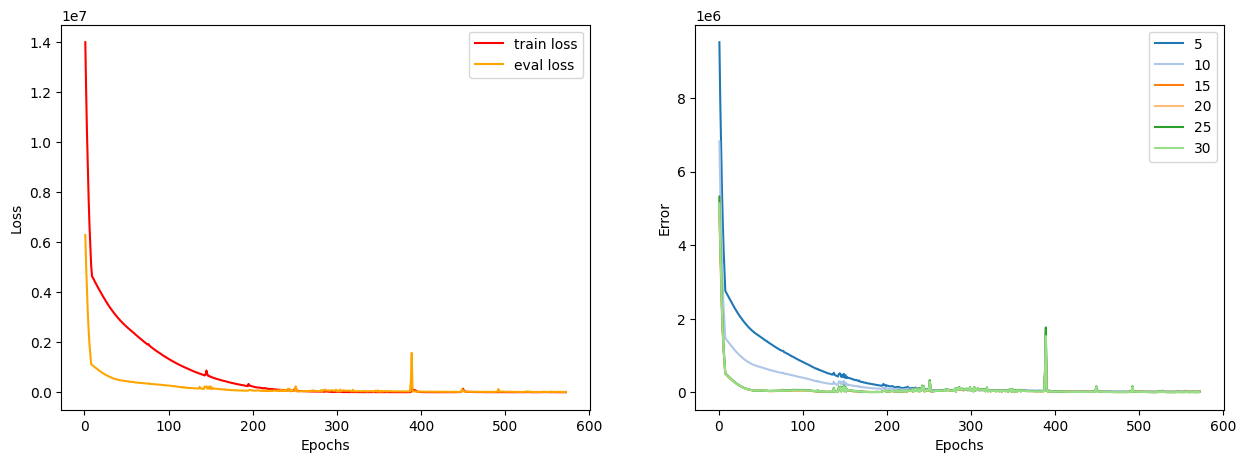

In [ ]:
learning_rates = [0.01]
# learning_rates = [0.01]
batch_sizes = [8, 16, 32]
layers = [1, 2]

# mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
# model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
# training_config = {'batch_size': 16, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': 0.1}, \
#                           'criterion' : nn.MSELoss(), 'n_epochs' : 1, 'early_stopping' : 5, 'evaluation_time': 3, 'delta': 0.04, \
#                    'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
#                    'verbose' : True, 'device' : device, 'continued' : True, 'run' : 2}
# training_config['model_path'] = model_path + conf2str(mamba_config, training_config)

for lr in learning_rates:
  now = datetime.now()
  date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
  date_time_ = str(date_time).replace("/","_")
  mamba_config = {'d_model' : 8, 'n_layer': 2, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
  model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
  training_config = {'batch_size': 32, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': lr}, \
                          'criterion' : nn.MSELoss(), 'n_epochs' : 700, 'early_stopping' : 100, 'evaluation_time': 3, 'delta': 0.04, \
                   'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
                   'verbose' : True, 'device' : device, 'continued' : False, 'run' : 1}
  training_config['model_path'] = model_path + conf2str(mamba_config, training_config) + date_time_
# for bs in batch_sizes:
  #   for l in layers:
  args = ModelArgs(mamba_config['d_model'], mamba_config['n_layer'], mamba_config['d_state'], mamba_config['expand'], mamba_config['d_conv'])
  mamba_model = Mamba(args)

  all_train_batches = prepare_mixed_dataloader(all_train_data, training_config['batch_size'])
  all_val_batches = prepare_mixed_dataloader(all_val_data, training_config['batch_size'])

  training_mamba = Training(mamba_model, training_config)
  training_mamba.train(all_train_batches, all_val_batches) #end of training loads the best model

  exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]), int(training_mamba.best_results[10]), int(training_mamba.best_results[20]),\
                                     lr, training_config['batch_size'], mamba_config['n_layer'], mamba_config['d_state'],\
                                     training_config['model_path'], test_filenames, mamba_config.copy(), training_config.copy(),\
                                     training_mamba.train_loss_history, training_mamba.eval_loss_history, training_mamba.eval_history, training_mamba.best_results]

  plot_training_summary(training_mamba)
  # exp_record.loc[len(exp_record)] = [date_time, dur, test_files, split_config.copy(), features_config, model_name, model_config.copy(), copy.deepcopy(training_config),
  #                 test_report, uav_precision_m, uav_recall_m, uav_f1_m, weighted_f1_m]

100%|██████████| 21/21 [00:02<00:00, 10.02it/s]


epoch 0: train loss = 15086512.924242424, eval loss = 7390546.428571428


100%|██████████| 21/21 [00:01<00:00, 16.61it/s]


epoch 1: train loss = 14865344.166666666, eval loss = 7230735.535714285


100%|██████████| 21/21 [00:01<00:00, 14.54it/s]


epoch 2: train loss = 14647897.636363637, eval loss = 7088827.845238095


100%|██████████| 21/21 [00:01<00:00, 13.28it/s]


epoch 3: train loss = 14435421.219696969, eval loss = 6944366.380952381


100%|██████████| 21/21 [00:01<00:00, 13.08it/s]


epoch 4: train loss = 14224996.727272727, eval loss = 6793526.880952381


100%|██████████| 21/21 [00:01<00:00, 14.91it/s]


epoch 5: train loss = 14017895.856060605, eval loss = 6645620.94047619


100%|██████████| 21/21 [00:01<00:00, 19.64it/s]


epoch 6: train loss = 13814157.893939395, eval loss = 6500445.642857143


100%|██████████| 21/21 [00:01<00:00, 20.42it/s]


epoch 7: train loss = 13613234.204545455, eval loss = 6357862.880952381


100%|██████████| 21/21 [00:01<00:00, 20.23it/s]


epoch 8: train loss = 13414397.378787879, eval loss = 6221704.523809524


100%|██████████| 21/21 [00:01<00:00, 19.90it/s]


epoch 9: train loss = 13218243.621212121, eval loss = 6090335.761904762


100%|██████████| 21/21 [00:01<00:00, 19.19it/s]


epoch 10: train loss = 13024261.196969697, eval loss = 5961453.130952381


100%|██████████| 21/21 [00:01<00:00, 19.63it/s]


epoch 11: train loss = 12834224.143939395, eval loss = 5828349.083333333


100%|██████████| 21/21 [00:01<00:00, 19.90it/s]


epoch 12: train loss = 12647551.227272727, eval loss = 5700724.607142857


100%|██████████| 21/21 [00:01<00:00, 19.84it/s]


epoch 13: train loss = 12464019.151515152, eval loss = 5573976.226190476


100%|██████████| 21/21 [00:01<00:00, 14.14it/s]


epoch 14: train loss = 12282923.742424242, eval loss = 5451298.05952381


100%|██████████| 21/21 [00:01<00:00, 19.87it/s]


epoch 15: train loss = 12104919.742424242, eval loss = 5329632.452380952


100%|██████████| 21/21 [00:01<00:00, 19.42it/s]


epoch 16: train loss = 11929651.530303031, eval loss = 5210880.333333333


100%|██████████| 21/21 [00:01<00:00, 19.87it/s]


epoch 17: train loss = 11756857.765151516, eval loss = 5093425.761904762


100%|██████████| 21/21 [00:01<00:00, 19.71it/s]


epoch 18: train loss = 11586726.340909092, eval loss = 4978617.297619048


100%|██████████| 21/21 [00:01<00:00, 19.23it/s]


epoch 19: train loss = 11418979.553030303, eval loss = 4865115.976190476


100%|██████████| 21/21 [00:01<00:00, 19.88it/s]


epoch 20: train loss = 11253708.628787879, eval loss = 4754077.583333333


100%|██████████| 21/21 [00:01<00:00, 20.36it/s]


epoch 21: train loss = 11090895.295454545, eval loss = 4644434.523809524


100%|██████████| 21/21 [00:01<00:00, 19.45it/s]


epoch 22: train loss = 10930304.234848484, eval loss = 4537106.595238095


100%|██████████| 21/21 [00:01<00:00, 19.27it/s]


epoch 23: train loss = 10772205.053030303, eval loss = 4431318.404761905


100%|██████████| 21/21 [00:01<00:00, 20.19it/s]


epoch 24: train loss = 10616228.318181818, eval loss = 4328230.238095238


100%|██████████| 21/21 [00:01<00:00, 20.20it/s]


epoch 25: train loss = 10462447.090909092, eval loss = 4226804.595238095


100%|██████████| 21/21 [00:01<00:00, 19.47it/s]


epoch 26: train loss = 10310686.962121213, eval loss = 4128696.1428571427


100%|██████████| 21/21 [00:01<00:00, 18.31it/s]


epoch 27: train loss = 10160916.5, eval loss = 4030090.2321428573


100%|██████████| 21/21 [00:01<00:00, 17.75it/s]


epoch 28: train loss = 10013060.636363637, eval loss = 3934915.1428571427


100%|██████████| 21/21 [00:01<00:00, 15.46it/s]


epoch 29: train loss = 9867251.121212121, eval loss = 3839474.125


100%|██████████| 21/21 [00:01<00:00, 14.05it/s]


epoch 30: train loss = 9723446.159090908, eval loss = 3748249.0416666665


100%|██████████| 21/21 [00:01<00:00, 13.22it/s]


epoch 31: train loss = 9581399.053030303, eval loss = 3655310.410714286


100%|██████████| 21/21 [00:01<00:00, 13.40it/s]


epoch 32: train loss = 9441327.719696969, eval loss = 3567001.9166666665


100%|██████████| 21/21 [00:01<00:00, 14.89it/s]


epoch 33: train loss = 9303138.969696969, eval loss = 3477361.898809524


100%|██████████| 21/21 [00:01<00:00, 20.47it/s]


epoch 34: train loss = 9166912.109848484, eval loss = 3392499.5714285714


100%|██████████| 21/21 [00:01<00:00, 20.48it/s]


epoch 35: train loss = 9032471.420454545, eval loss = 3306220.279761905


100%|██████████| 21/21 [00:01<00:00, 19.83it/s]


epoch 36: train loss = 8899928.454545455, eval loss = 3224470.595238095


100%|██████████| 21/21 [00:01<00:00, 19.42it/s]


epoch 37: train loss = 8769134.780303031, eval loss = 3141226.7678571427


100%|██████████| 21/21 [00:01<00:00, 19.74it/s]


epoch 38: train loss = 8640252.446969697, eval loss = 3062697.964285714


100%|██████████| 21/21 [00:01<00:00, 19.91it/s]


epoch 39: train loss = 8513120.291666666, eval loss = 2982425.601190476


100%|██████████| 21/21 [00:01<00:00, 19.49it/s]


epoch 40: train loss = 8387860.587121212, eval loss = 2906939.8333333335


100%|██████████| 21/21 [00:01<00:00, 19.92it/s]


epoch 41: train loss = 8264521.106060606, eval loss = 2829731.1904761903


100%|██████████| 21/21 [00:01<00:00, 19.07it/s]


epoch 42: train loss = 8142587.678030303, eval loss = 2755367.7083333335


100%|██████████| 21/21 [00:01<00:00, 19.73it/s]


epoch 43: train loss = 8022711.996212121, eval loss = 2683052.898809524


100%|██████████| 21/21 [00:01<00:00, 19.65it/s]


epoch 44: train loss = 7903955.640151516, eval loss = 2612902.8154761903


100%|██████████| 21/21 [00:01<00:00, 19.91it/s]


epoch 45: train loss = 7787408.6022727275, eval loss = 2541775.755952381


100%|██████████| 21/21 [00:01<00:00, 19.41it/s]


epoch 46: train loss = 7680746.143939394, eval loss = 2480998.2976190476


100%|██████████| 21/21 [00:01<00:00, 19.83it/s]


epoch 47: train loss = 7561953.196969697, eval loss = 2412212.898809524


100%|██████████| 21/21 [00:01<00:00, 20.47it/s]


epoch 48: train loss = 7448134.553030303, eval loss = 2342731.910714286


100%|██████████| 21/21 [00:01<00:00, 20.32it/s]


epoch 49: train loss = 7337433.136363637, eval loss = 2274977.8273809524


100%|██████████| 21/21 [00:01<00:00, 19.69it/s]


epoch 50: train loss = 7228373.696969697, eval loss = 2213381.532738095


100%|██████████| 21/21 [00:01<00:00, 19.83it/s]


epoch 51: train loss = 7121347.7272727275, eval loss = 2149718.598214286


100%|██████████| 21/21 [00:01<00:00, 19.42it/s]


epoch 52: train loss = 7015936.159090909, eval loss = 2090431.5863095238


100%|██████████| 21/21 [00:01<00:00, 19.42it/s]


epoch 53: train loss = 6912085.643939394, eval loss = 2029771.1577380951


100%|██████████| 21/21 [00:01<00:00, 17.37it/s]


epoch 54: train loss = 6809839.223484849, eval loss = 1973452.5208333333


100%|██████████| 21/21 [00:01<00:00, 15.79it/s]


epoch 55: train loss = 6709084.1022727275, eval loss = 1914700.482142857


100%|██████████| 21/21 [00:01<00:00, 13.74it/s]


epoch 56: train loss = 6609911.393939394, eval loss = 1861590.5892857143


100%|██████████| 21/21 [00:01<00:00, 14.07it/s]


epoch 57: train loss = 6512138.90719697, eval loss = 1804471.8214285714


100%|██████████| 21/21 [00:01<00:00, 12.98it/s]


epoch 58: train loss = 6415966.251893939, eval loss = 1754407.9523809524


100%|██████████| 21/21 [00:01<00:00, 17.43it/s]


epoch 59: train loss = 6321072.386363637, eval loss = 1699250.1964285714


100%|██████████| 21/21 [00:01<00:00, 19.19it/s]


epoch 60: train loss = 6227837.043560606, eval loss = 1651767.6041666667


100%|██████████| 21/21 [00:01<00:00, 19.58it/s]


epoch 61: train loss = 6135762.115530303, eval loss = 1598870.4077380951


100%|██████████| 21/21 [00:01<00:00, 19.23it/s]


epoch 62: train loss = 6045376.642045454, eval loss = 1553848.3333333333


100%|██████████| 21/21 [00:01<00:00, 19.44it/s]


epoch 63: train loss = 5956035.791666667, eval loss = 1503057.2113095238


100%|██████████| 21/21 [00:01<00:00, 19.83it/s]


epoch 64: train loss = 5868456.382575758, eval loss = 1460398.8958333333


100%|██████████| 21/21 [00:01<00:00, 19.11it/s]


epoch 65: train loss = 5781823.46969697, eval loss = 1411807.988095238


100%|██████████| 21/21 [00:01<00:00, 19.39it/s]


epoch 66: train loss = 5697429.9602272725, eval loss = 1371049.3214285714


100%|██████████| 21/21 [00:01<00:00, 19.12it/s]


epoch 67: train loss = 5613812.284090909, eval loss = 1325039.2529761905


100%|██████████| 21/21 [00:01<00:00, 20.12it/s]


epoch 68: train loss = 5531285.909090909, eval loss = 1286399.4017857143


100%|██████████| 21/21 [00:01<00:00, 20.24it/s]


epoch 69: train loss = 5450165.725378788, eval loss = 1242396.0952380951


100%|██████████| 21/21 [00:01<00:00, 19.76it/s]


epoch 70: train loss = 5370616.075757576, eval loss = 1204632.613095238


100%|██████████| 21/21 [00:01<00:00, 19.75it/s]


epoch 71: train loss = 5294294.327651516, eval loss = 1164315.6145833333


100%|██████████| 21/21 [00:01<00:00, 20.33it/s]


epoch 72: train loss = 5217115.929924242, eval loss = 1132386.568452381


100%|██████████| 21/21 [00:01<00:00, 19.72it/s]


epoch 73: train loss = 5137808.393939394, eval loss = 1090936.0729166667


100%|██████████| 21/21 [00:01<00:00, 19.77it/s]


epoch 74: train loss = 5062816.840909091, eval loss = 1057455.455357143


100%|██████████| 21/21 [00:01<00:00, 20.01it/s]


epoch 75: train loss = 4989161.486742424, eval loss = 1021260.619047619


100%|██████████| 21/21 [00:01<00:00, 19.83it/s]


epoch 76: train loss = 4916809.46875, eval loss = 989263.5491071428


100%|██████████| 21/21 [00:01<00:00, 19.72it/s]


epoch 77: train loss = 4845622.433712121, eval loss = 954828.3630952381


100%|██████████| 21/21 [00:01<00:00, 20.17it/s]


epoch 78: train loss = 4775670.512310606, eval loss = 924835.9732142857


100%|██████████| 21/21 [00:01<00:00, 19.40it/s]


epoch 79: train loss = 4706767.912878788, eval loss = 892167.65625


100%|██████████| 21/21 [00:01<00:00, 18.18it/s]


epoch 80: train loss = 4639175.129734849, eval loss = 864101.0267857143


100%|██████████| 21/21 [00:01<00:00, 15.94it/s]


epoch 81: train loss = 4572500.082386363, eval loss = 833489.3541666666


100%|██████████| 21/21 [00:01<00:00, 13.90it/s]


epoch 82: train loss = 4507037.320075758, eval loss = 806711.6636904762


100%|██████████| 21/21 [00:01<00:00, 13.69it/s]


epoch 83: train loss = 4442945.12594697, eval loss = 779414.5982142857


100%|██████████| 21/21 [00:01<00:00, 13.72it/s]


epoch 84: train loss = 4379766.575757576, eval loss = 752943.3452380953


100%|██████████| 21/21 [00:01<00:00, 14.71it/s]


epoch 85: train loss = 4317928.832859849, eval loss = 728642.853422619


100%|██████████| 21/21 [00:01<00:00, 19.38it/s]


epoch 86: train loss = 4257016.654356061, eval loss = 702960.3831845238


100%|██████████| 21/21 [00:01<00:00, 20.03it/s]


epoch 87: train loss = 4197148.956912879, eval loss = 683621.0074404762


100%|██████████| 21/21 [00:01<00:00, 20.19it/s]


epoch 88: train loss = 4139014.7017045454, eval loss = 655636.90625


100%|██████████| 21/21 [00:01<00:00, 20.05it/s]


epoch 89: train loss = 4081192.699810606, eval loss = 633921.6488095238


100%|██████████| 21/21 [00:01<00:00, 20.17it/s]


epoch 90: train loss = 4024472.0610795454, eval loss = 613573.025297619


100%|██████████| 21/21 [00:01<00:00, 19.67it/s]


epoch 91: train loss = 3968839.405776515, eval loss = 592832.7433035715


100%|██████████| 21/21 [00:01<00:00, 19.73it/s]


epoch 92: train loss = 3914311.478219697, eval loss = 575115.8787202381


100%|██████████| 21/21 [00:01<00:00, 18.52it/s]


epoch 93: train loss = 3861097.381155303, eval loss = 555744.7380952381


100%|██████████| 21/21 [00:01<00:00, 19.89it/s]


epoch 94: train loss = 3809269.740530303, eval loss = 537785.1391369047


100%|██████████| 21/21 [00:01<00:00, 19.73it/s]


epoch 95: train loss = 3757919.309185606, eval loss = 518135.03050595237


100%|██████████| 21/21 [00:01<00:00, 18.03it/s]


epoch 96: train loss = 3707104.5137310605, eval loss = 503490.453125


100%|██████████| 21/21 [00:01<00:00, 19.05it/s]


epoch 97: train loss = 3657618.710227273, eval loss = 485457.7808779762


100%|██████████| 21/21 [00:01<00:00, 19.03it/s]


epoch 98: train loss = 3609111.664299242, eval loss = 472453.3519345238


100%|██████████| 21/21 [00:01<00:00, 19.81it/s]


epoch 99: train loss = 3561656.948153409, eval loss = 455601.2730654762


100%|██████████| 21/21 [00:01<00:00, 18.75it/s]


epoch 100: train loss = 3514958.6084280303, eval loss = 444557.1238839286


100%|██████████| 21/21 [00:01<00:00, 19.65it/s]


epoch 101: train loss = 3469339.191998106, eval loss = 429057.87313988095


100%|██████████| 21/21 [00:01<00:00, 18.45it/s]


epoch 102: train loss = 3424720.5684185605, eval loss = 418815.95163690473


100%|██████████| 21/21 [00:01<00:00, 18.96it/s]


epoch 103: train loss = 3380824.508049242, eval loss = 404708.0420386905


100%|██████████| 21/21 [00:01<00:00, 17.37it/s]


epoch 104: train loss = 3337971.0254498105, eval loss = 395446.59523809527


100%|██████████| 21/21 [00:01<00:00, 13.46it/s]


epoch 105: train loss = 3295615.5259232954, eval loss = 382866.5197172619


100%|██████████| 21/21 [00:01<00:00, 13.71it/s]


epoch 106: train loss = 3254406.7832623105, eval loss = 374654.6560639881


100%|██████████| 21/21 [00:01<00:00, 13.01it/s]


epoch 107: train loss = 3214001.1031013257, eval loss = 363442.2777157738


100%|██████████| 21/21 [00:01<00:00, 19.36it/s]


epoch 108: train loss = 3174534.806640625, eval loss = 356905.7332589286


100%|██████████| 21/21 [00:01<00:00, 18.89it/s]


epoch 109: train loss = 3135768.1720525566, eval loss = 346991.92819940473


100%|██████████| 21/21 [00:01<00:00, 18.95it/s]


epoch 110: train loss = 3097876.0024857954, eval loss = 340164.05654761905


100%|██████████| 21/21 [00:01<00:00, 18.32it/s]


epoch 111: train loss = 3060495.5752249053, eval loss = 332475.85128348216


100%|██████████| 21/21 [00:01<00:00, 18.59it/s]


epoch 112: train loss = 3024642.0802556816, eval loss = 326941.4186197917


100%|██████████| 21/21 [00:01<00:00, 19.31it/s]


epoch 113: train loss = 2989389.0094105112, eval loss = 321711.6673177083


100%|██████████| 21/21 [00:01<00:00, 18.61it/s]


epoch 114: train loss = 2954681.0187914297, eval loss = 313925.8951822917


100%|██████████| 21/21 [00:01<00:00, 18.53it/s]


epoch 115: train loss = 2920995.9876598013, eval loss = 309297.76316034223


100%|██████████| 21/21 [00:01<00:00, 18.25it/s]


epoch 116: train loss = 2886938.1378432764, eval loss = 304705.9521019345


100%|██████████| 21/21 [00:01<00:00, 18.96it/s]


epoch 117: train loss = 2854175.514855587, eval loss = 301752.5301339286


100%|██████████| 21/21 [00:01<00:00, 18.57it/s]


epoch 118: train loss = 2822396.4398674243, eval loss = 297156.8297061012


100%|██████████| 21/21 [00:01<00:00, 19.56it/s]


epoch 119: train loss = 2791546.9090613164, eval loss = 296601.55947730655


100%|██████████| 21/21 [00:01<00:00, 19.07it/s]


epoch 120: train loss = 2761154.2791267163, eval loss = 290141.07761346723


100%|██████████| 21/21 [00:01<00:00, 18.97it/s]


epoch 121: train loss = 2731045.9833540483, eval loss = 289745.74953497027


100%|██████████| 21/21 [00:01<00:00, 19.79it/s]


epoch 122: train loss = 2701295.2616669624, eval loss = 284415.16180710564


100%|██████████| 21/21 [00:01<00:00, 19.01it/s]


epoch 123: train loss = 2672282.931814483, eval loss = 286121.8485863095


100%|██████████| 21/21 [00:01<00:00, 18.16it/s]


epoch 124: train loss = 2643173.176447088, eval loss = 279277.2673223586


100%|██████████| 21/21 [00:01<00:00, 15.98it/s]


epoch 125: train loss = 2614682.8132509175, eval loss = 279156.78083147324


100%|██████████| 21/21 [00:01<00:00, 13.11it/s]


epoch 126: train loss = 2586314.9378921045, eval loss = 273671.8600260417


100%|██████████| 21/21 [00:01<00:00, 12.95it/s]


epoch 127: train loss = 2558565.3178341025, eval loss = 273896.8316592262


100%|██████████| 21/21 [00:01<00:00, 12.66it/s]


epoch 128: train loss = 2530253.351259174, eval loss = 267527.1316964286


100%|██████████| 21/21 [00:01<00:00, 18.43it/s]


epoch 129: train loss = 2502786.8226873223, eval loss = 267923.86546688987


100%|██████████| 21/21 [00:01<00:00, 18.69it/s]


epoch 130: train loss = 2474457.623942057, eval loss = 261460.14834449405


100%|██████████| 21/21 [00:01<00:00, 18.45it/s]


epoch 131: train loss = 2447652.976680871, eval loss = 263623.49816313246


100%|██████████| 21/21 [00:01<00:00, 18.45it/s]


epoch 132: train loss = 2419619.898652048, eval loss = 256352.2498372396


100%|██████████| 21/21 [00:01<00:00, 18.89it/s]


epoch 133: train loss = 2392742.8865411934, eval loss = 261355.04754929314


100%|██████████| 21/21 [00:01<00:00, 18.55it/s]


epoch 134: train loss = 2367102.972700639, eval loss = 252431.74813988095


100%|██████████| 21/21 [00:01<00:00, 18.67it/s]


epoch 135: train loss = 2339179.4104225854, eval loss = 258005.95596168155


100%|██████████| 21/21 [00:01<00:00, 19.15it/s]


epoch 136: train loss = 2312423.2785718516, eval loss = 249064.84895833334


100%|██████████| 21/21 [00:01<00:00, 19.35it/s]


epoch 137: train loss = 2285907.3810665244, eval loss = 253688.42045665922


100%|██████████| 21/21 [00:01<00:00, 19.60it/s]


epoch 138: train loss = 2259979.3587979404, eval loss = 246183.96003069196


100%|██████████| 21/21 [00:01<00:00, 18.81it/s]


epoch 139: train loss = 2234383.437692353, eval loss = 251510.8734421503


100%|██████████| 21/21 [00:01<00:00, 18.88it/s]


epoch 140: train loss = 2208319.2812352036, eval loss = 243468.5916341146


100%|██████████| 21/21 [00:01<00:00, 19.49it/s]


epoch 141: train loss = 2182746.1398111978, eval loss = 248504.24732607888


100%|██████████| 21/21 [00:01<00:00, 18.22it/s]


epoch 142: train loss = 2157421.837609493, eval loss = 241203.30436197916


100%|██████████| 21/21 [00:01<00:00, 18.26it/s]


epoch 143: train loss = 2132155.62220348, eval loss = 246167.982421875


100%|██████████| 21/21 [00:01<00:00, 14.28it/s]


epoch 144: train loss = 2106892.6577740293, eval loss = 238732.56030273438


100%|██████████| 21/21 [00:01<00:00, 13.46it/s]


epoch 145: train loss = 2083793.9471620503, eval loss = 247484.4832356771


100%|██████████| 21/21 [00:01<00:00, 13.28it/s]


epoch 146: train loss = 2056954.7339163115, eval loss = 236945.9125860305


100%|██████████| 21/21 [00:01<00:00, 14.28it/s]


epoch 147: train loss = 2032420.2898615056, eval loss = 251750.59542410713


100%|██████████| 21/21 [00:01<00:00, 20.00it/s]


epoch 148: train loss = 2007648.8487511836, eval loss = 235915.4728422619


100%|██████████| 21/21 [00:01<00:00, 19.45it/s]


epoch 149: train loss = 1983273.039580374, eval loss = 250948.0845424107


100%|██████████| 21/21 [00:01<00:00, 19.88it/s]


epoch 150: train loss = 1959120.8050278171, eval loss = 236176.0634765625


100%|██████████| 21/21 [00:01<00:00, 20.05it/s]


epoch 151: train loss = 1935289.752470999, eval loss = 250465.31974283853


100%|██████████| 21/21 [00:01<00:00, 19.57it/s]


epoch 152: train loss = 1911595.4651988635, eval loss = 237001.98318917412


100%|██████████| 21/21 [00:01<00:00, 19.50it/s]


epoch 153: train loss = 1888263.4447058477, eval loss = 251572.69340587797


100%|██████████| 21/21 [00:01<00:00, 20.26it/s]


epoch 154: train loss = 1864963.4185754023, eval loss = 238048.4395577567


100%|██████████| 21/21 [00:01<00:00, 19.19it/s]


epoch 155: train loss = 1842026.127544981, eval loss = 254547.7872140067


100%|██████████| 21/21 [00:01<00:00, 19.74it/s]


epoch 156: train loss = 1819123.9847005208, eval loss = 240251.879906064


100%|██████████| 21/21 [00:01<00:00, 19.86it/s]


epoch 157: train loss = 1796529.1703065815, eval loss = 256439.54432896205


100%|██████████| 21/21 [00:01<00:00, 20.42it/s]


epoch 158: train loss = 1773999.086011482, eval loss = 239901.70134626116


100%|██████████| 21/21 [00:01<00:00, 20.03it/s]


epoch 159: train loss = 1751755.3542850378, eval loss = 256845.1085030692


100%|██████████| 21/21 [00:01<00:00, 20.02it/s]


epoch 160: train loss = 1729645.6411280776, eval loss = 240747.75023251487


100%|██████████| 21/21 [00:01<00:00, 18.38it/s]


epoch 161: train loss = 1707798.7073863635, eval loss = 259765.69646344866


100%|██████████| 21/21 [00:01<00:00, 19.96it/s]


epoch 162: train loss = 1686049.8188476562, eval loss = 240669.34619140625


100%|██████████| 21/21 [00:01<00:00, 19.98it/s]


epoch 163: train loss = 1664466.5175633286, eval loss = 262202.55119977676


100%|██████████| 21/21 [00:01<00:00, 19.50it/s]


epoch 164: train loss = 1643143.5854640151, eval loss = 239036.13517252603


100%|██████████| 21/21 [00:01<00:00, 19.04it/s]


epoch 165: train loss = 1622003.5937647964, eval loss = 266201.4572172619


100%|██████████| 21/21 [00:01<00:00, 19.40it/s]


epoch 166: train loss = 1601138.4828361743, eval loss = 236270.43434361048


100%|██████████| 21/21 [00:01<00:00, 19.88it/s]


epoch 167: train loss = 1580301.9242572207, eval loss = 268306.7201043992


100%|██████████| 21/21 [00:01<00:00, 19.23it/s]


epoch 168: train loss = 1559804.5580462832, eval loss = 229421.50027901787


100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


epoch 169: train loss = 1539333.0192945076, eval loss = 273105.7207670666


100%|██████████| 21/21 [00:01<00:00, 15.56it/s]


epoch 170: train loss = 1519319.3808741714, eval loss = 227190.58368210564


100%|██████████| 21/21 [00:01<00:00, 13.27it/s]


epoch 171: train loss = 1498873.3204012783, eval loss = 260417.85811941963


100%|██████████| 21/21 [00:01<00:00, 13.34it/s]


epoch 172: train loss = 1479109.8030894885, eval loss = 209412.14554268974


100%|██████████| 21/21 [00:01<00:00, 14.16it/s]


epoch 173: train loss = 1466123.6458481296, eval loss = 323128.8077218192


100%|██████████| 21/21 [00:01<00:00, 20.08it/s]


epoch 174: train loss = 1452150.9756155303, eval loss = 304356.30462937127


100%|██████████| 21/21 [00:01<00:00, 20.17it/s]


epoch 175: train loss = 1425131.6771573154, eval loss = 284277.8993733724


100%|██████████| 21/21 [00:01<00:00, 19.94it/s]


epoch 176: train loss = 1402982.8761097302, eval loss = 272548.65615699405


100%|██████████| 21/21 [00:01<00:00, 18.99it/s]


epoch 177: train loss = 1383078.1770093513, eval loss = 274384.60452125187


100%|██████████| 21/21 [00:01<00:00, 20.06it/s]


epoch 178: train loss = 1363737.6531279592, eval loss = 255595.32157389322


100%|██████████| 21/21 [00:01<00:00, 20.15it/s]


epoch 179: train loss = 1344486.1487926135, eval loss = 264346.4433361235


100%|██████████| 21/21 [00:01<00:00, 19.99it/s]


epoch 180: train loss = 1325707.7662908381, eval loss = 227385.95413934617


100%|██████████| 21/21 [00:01<00:00, 19.96it/s]


epoch 181: train loss = 1307192.733857126, eval loss = 314048.27983456565


100%|██████████| 21/21 [00:01<00:00, 19.30it/s]


epoch 182: train loss = 1290358.3888642283, eval loss = 232604.40611921038


100%|██████████| 21/21 [00:01<00:00, 19.56it/s]


epoch 183: train loss = 1270255.0658217922, eval loss = 245443.9386480422


100%|██████████| 21/21 [00:01<00:00, 19.42it/s]


epoch 184: train loss = 1251841.2180619673, eval loss = 206722.158089774


100%|██████████| 21/21 [00:01<00:00, 19.77it/s]


epoch 185: train loss = 1234630.4980690696, eval loss = 327770.79155912856


100%|██████████| 21/21 [00:01<00:00, 20.32it/s]


epoch 186: train loss = 1219281.6078953599, eval loss = 264706.61837623233


100%|██████████| 21/21 [00:01<00:00, 19.47it/s]


epoch 187: train loss = 1200414.7057439631, eval loss = 205985.46401832218


100%|██████████| 21/21 [00:01<00:00, 19.43it/s]


epoch 188: train loss = 1182091.2254305752, eval loss = 224247.97106352306


100%|██████████| 21/21 [00:01<00:00, 19.96it/s]


epoch 189: train loss = 1164864.0420291785, eval loss = 177896.29688081288


100%|██████████| 21/21 [00:01<00:00, 20.31it/s]


epoch 190: train loss = 1148881.07347893, eval loss = 321620.2422717867


100%|██████████| 21/21 [00:01<00:00, 20.37it/s]


epoch 191: train loss = 1134718.130637429, eval loss = 235263.11113920665


100%|██████████| 21/21 [00:01<00:00, 19.40it/s]


epoch 192: train loss = 1116395.9499733665, eval loss = 164617.1609874907


100%|██████████| 21/21 [00:01<00:00, 19.21it/s]


epoch 193: train loss = 1100750.2490715259, eval loss = 322422.94497825985


100%|██████████| 21/21 [00:01<00:00, 19.15it/s]


epoch 194: train loss = 1087162.1837898022, eval loss = 245208.50888206845


100%|██████████| 21/21 [00:01<00:00, 19.40it/s]


epoch 195: train loss = 1069546.0673162288, eval loss = 198704.1861368815


100%|██████████| 21/21 [00:01<00:00, 16.68it/s]


epoch 196: train loss = 1052586.0310354521, eval loss = 240608.30076090494


100%|██████████| 21/21 [00:01<00:00, 13.55it/s]


epoch 197: train loss = 1037523.591020064, eval loss = 171415.7685285296


100%|██████████| 21/21 [00:01<00:00, 13.76it/s]


epoch 198: train loss = 1023269.9666637074, eval loss = 306248.2827090309


100%|██████████| 21/21 [00:01<00:00, 13.28it/s]


epoch 199: train loss = 1010268.7219460227, eval loss = 179533.61838785806


100%|██████████| 21/21 [00:01<00:00, 15.87it/s]


epoch 200: train loss = 992810.1003122041, eval loss = 171230.57226853142


100%|██████████| 21/21 [00:01<00:00, 19.98it/s]


epoch 201: train loss = 977773.2976814039, eval loss = 189054.6656116304


100%|██████████| 21/21 [00:01<00:00, 19.19it/s]


epoch 202: train loss = 963486.6735247988, eval loss = 155937.00629243397


100%|██████████| 21/21 [00:01<00:00, 18.99it/s]


epoch 203: train loss = 949814.8966064453, eval loss = 263224.1132783436


100%|██████████| 21/21 [00:01<00:00, 20.26it/s]


epoch 204: train loss = 936971.6924974846, eval loss = 154073.56363351006


100%|██████████| 21/21 [00:01<00:00, 20.40it/s]


epoch 205: train loss = 922914.5761459813, eval loss = 255978.8257039388


100%|██████████| 21/21 [00:01<00:00, 19.53it/s]


epoch 206: train loss = 909719.3054384174, eval loss = 140569.79202997117


100%|██████████| 21/21 [00:01<00:00, 19.85it/s]


epoch 207: train loss = 896053.8239783085, eval loss = 246288.2943231492


100%|██████████| 21/21 [00:01<00:00, 19.90it/s]


epoch 208: train loss = 882785.7692057291, eval loss = 139685.75523449125


100%|██████████| 21/21 [00:01<00:00, 20.10it/s]


epoch 209: train loss = 869483.2814534506, eval loss = 230410.4291643415


100%|██████████| 21/21 [00:01<00:00, 19.49it/s]


epoch 210: train loss = 856072.8876102332, eval loss = 132388.71534656343


100%|██████████| 21/21 [00:01<00:00, 19.17it/s]


epoch 211: train loss = 843434.4840124882, eval loss = 235151.56906563896


100%|██████████| 21/21 [00:01<00:00, 19.66it/s]


epoch 212: train loss = 830215.3437980883, eval loss = 132670.5084809803


100%|██████████| 21/21 [00:01<00:00, 19.81it/s]


epoch 213: train loss = 818962.7950661399, eval loss = 227082.24698311943


100%|██████████| 21/21 [00:01<00:00, 20.36it/s]


epoch 214: train loss = 805671.7461233428, eval loss = 123753.31206694103


100%|██████████| 21/21 [00:01<00:00, 19.98it/s]


epoch 215: train loss = 793326.5747477213, eval loss = 199401.75100562687


100%|██████████| 21/21 [00:01<00:00, 19.63it/s]


epoch 216: train loss = 779838.6559170809, eval loss = 126350.93250964937


100%|██████████| 21/21 [00:01<00:00, 19.51it/s]


epoch 217: train loss = 769125.4390795159, eval loss = 196780.91585577102


100%|██████████| 21/21 [00:01<00:00, 19.87it/s]


epoch 218: train loss = 756490.4268428918, eval loss = 120706.95999581473


100%|██████████| 21/21 [00:01<00:00, 18.97it/s]


epoch 219: train loss = 745058.3268081202, eval loss = 161432.0312674386


100%|██████████| 21/21 [00:01<00:00, 19.81it/s]


epoch 220: train loss = 732659.8448856238, eval loss = 118181.81457519531


100%|██████████| 21/21 [00:01<00:00, 17.51it/s]


epoch 221: train loss = 721809.4320179332, eval loss = 159586.94620768228


100%|██████████| 21/21 [00:01<00:00, 15.34it/s]


epoch 222: train loss = 709831.6989709103, eval loss = 111825.99316696894


100%|██████████| 21/21 [00:01<00:00, 13.36it/s]


epoch 223: train loss = 699259.334761186, eval loss = 163421.95771135602


100%|██████████| 21/21 [00:01<00:00, 13.96it/s]


epoch 224: train loss = 687980.1783780184, eval loss = 103198.28920200893


100%|██████████| 21/21 [00:01<00:00, 13.32it/s]


epoch 225: train loss = 677580.8840627959, eval loss = 154425.00778343563


100%|██████████| 21/21 [00:01<00:00, 16.69it/s]


epoch 226: train loss = 666484.7967196378, eval loss = 107590.17908586774


100%|██████████| 21/21 [00:01<00:00, 19.57it/s]


epoch 227: train loss = 655906.3233975497, eval loss = 137103.59277634392


100%|██████████| 21/21 [00:01<00:00, 18.15it/s]


epoch 228: train loss = 645175.0117261482, eval loss = 117104.40481712704


100%|██████████| 21/21 [00:01<00:00, 19.74it/s]


epoch 229: train loss = 635011.9389944365, eval loss = 127262.97082228887


100%|██████████| 21/21 [00:01<00:00, 20.25it/s]


epoch 230: train loss = 624205.3777077415, eval loss = 125863.62924049015


100%|██████████| 21/21 [00:01<00:00, 19.19it/s]


epoch 231: train loss = 613094.9704737808, eval loss = 127031.90624418712


100%|██████████| 21/21 [00:01<00:00, 20.21it/s]


epoch 232: train loss = 602553.0085819128, eval loss = 185588.09129987445


100%|██████████| 21/21 [00:01<00:00, 20.28it/s]


epoch 233: train loss = 595250.168926817, eval loss = 86219.07741001675


100%|██████████| 21/21 [00:01<00:00, 19.53it/s]


epoch 234: train loss = 596426.7402121804, eval loss = 203423.9857381185


100%|██████████| 21/21 [00:01<00:00, 18.96it/s]


epoch 235: train loss = 579755.8342285156, eval loss = 115907.94865490141


100%|██████████| 21/21 [00:01<00:00, 20.10it/s]


epoch 236: train loss = 583217.0858450225, eval loss = 397185.18652925035


100%|██████████| 21/21 [00:01<00:00, 19.66it/s]


epoch 237: train loss = 568356.8637547349, eval loss = 111862.33441452753


100%|██████████| 21/21 [00:01<00:00, 19.54it/s]


epoch 238: train loss = 551996.7452651515, eval loss = 138261.26654343377


100%|██████████| 21/21 [00:01<00:00, 19.36it/s]


epoch 239: train loss = 544221.6658824574, eval loss = 106376.27529761905


100%|██████████| 21/21 [00:01<00:00, 19.42it/s]


epoch 240: train loss = 533394.1721561316, eval loss = 135296.14325241814


100%|██████████| 21/21 [00:01<00:00, 19.67it/s]


epoch 241: train loss = 521506.6052579013, eval loss = 133099.29241652717


100%|██████████| 21/21 [00:01<00:00, 19.67it/s]


epoch 242: train loss = 512211.8292976148, eval loss = 117081.24983723958


100%|██████████| 21/21 [00:01<00:00, 18.77it/s]


epoch 243: train loss = 503483.25341796875, eval loss = 156733.06504022508


100%|██████████| 21/21 [00:01<00:00, 19.88it/s]


epoch 244: train loss = 493078.53660629736, eval loss = 128508.45715913319


100%|██████████| 21/21 [00:01<00:00, 19.91it/s]


epoch 245: train loss = 484096.1905147668, eval loss = 126704.91761997768


100%|██████████| 21/21 [00:01<00:00, 15.62it/s]


epoch 246: train loss = 476094.2353071733, eval loss = 139882.625999814


100%|██████████| 21/21 [00:01<00:00, 15.41it/s]


epoch 247: train loss = 466988.1642733487, eval loss = 154714.1229422433


100%|██████████| 21/21 [00:01<00:00, 12.98it/s]


epoch 248: train loss = 458347.97235292377, eval loss = 119810.97391183036


100%|██████████| 21/21 [00:01<00:00, 13.24it/s]


epoch 249: train loss = 450832.2117180102, eval loss = 153734.8702857608


100%|██████████| 21/21 [00:01<00:00, 15.47it/s]


epoch 250: train loss = 441935.6874223189, eval loss = 155250.54987444196


100%|██████████| 21/21 [00:01<00:00, 19.45it/s]


epoch 251: train loss = 433639.5718772195, eval loss = 119489.18824404762


100%|██████████| 21/21 [00:01<00:00, 19.02it/s]


epoch 252: train loss = 427371.26597271545, eval loss = 151772.6416015625


100%|██████████| 21/21 [00:01<00:00, 19.34it/s]


epoch 253: train loss = 417883.5205115116, eval loss = 153727.71155366444


100%|██████████| 21/21 [00:01<00:00, 19.21it/s]


epoch 254: train loss = 409348.5375606652, eval loss = 112226.92650204613


100%|██████████| 21/21 [00:01<00:00, 18.77it/s]


epoch 255: train loss = 403275.5692508582, eval loss = 145921.67379906063


100%|██████████| 21/21 [00:01<00:00, 19.37it/s]


epoch 256: train loss = 394173.14918841736, eval loss = 115100.92952473958


100%|██████████| 21/21 [00:01<00:00, 16.40it/s]


epoch 257: train loss = 386259.9962232185, eval loss = 169277.7013404483


100%|██████████| 21/21 [00:01<00:00, 19.34it/s]


epoch 258: train loss = 378620.4181574041, eval loss = 104934.22849237351


100%|██████████| 21/21 [00:01<00:00, 19.16it/s]


epoch 259: train loss = 372979.6989524148, eval loss = 194475.76131184897

Early stoping after 259 epochs. eval loss did not imporve for more than 20 epochs

Finished Training:
Best metrics are:
Best loss = 188607.234375
Best train loss = 544221.6658824574
Best eval loss = 106376.27529761905
Best 5sec eval = 227861.828125
Best 10sec eval = 188607.234375
Best 15sec eval = 21700.080078125
Best 20sec eval = 26481.013671875
Best 25sec eval = 24367.896484375
Best 30sec eval = 25901.330078125


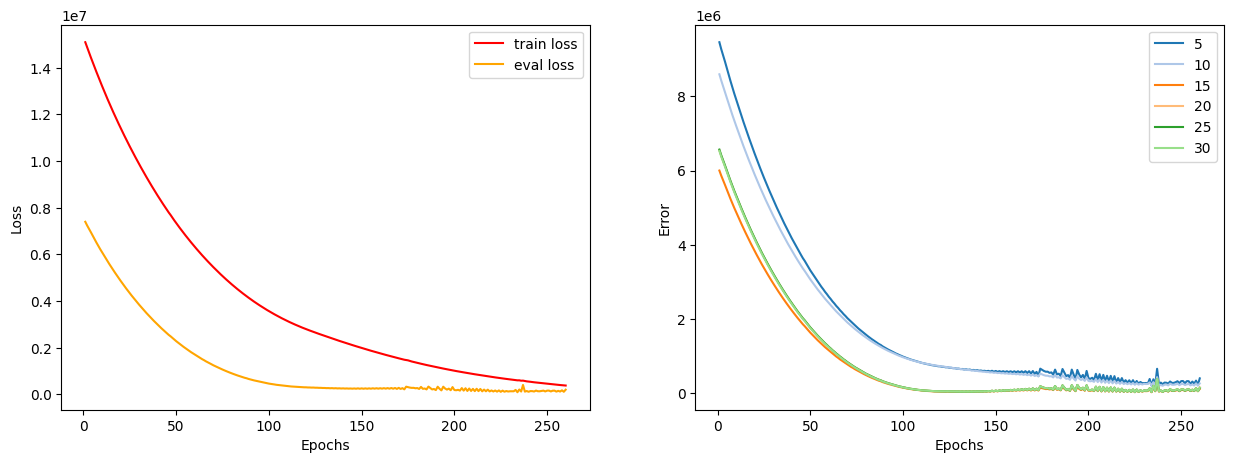

In [ ]:
learning_rates = [0.01]
# learning_rates = [0.01]
batch_sizes = [8, 16, 32]
layers = [1, 2]

# mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
# model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
# training_config = {'batch_size': 16, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': 0.1}, \
#                           'criterion' : nn.MSELoss(), 'n_epochs' : 1, 'early_stopping' : 5, 'evaluation_time': 3, 'delta': 0.04, \
#                    'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
#                    'verbose' : True, 'device' : device, 'continued' : True, 'run' : 2}
# training_config['model_path'] = model_path + conf2str(mamba_config, training_config)

for lr in learning_rates:
  now = datetime.now()
  date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
  date_time_ = str(date_time).replace("/","_")
  mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
  model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
  training_config = {'batch_size': 32, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': lr}, \
                          'criterion' : nn.MSELoss(), 'n_epochs' : 600, 'early_stopping' : 20, 'evaluation_time': 3, 'delta': 0.04, \
                   'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
                   'verbose' : True, 'device' : device, 'continued' : False, 'run' : 1}
  training_config['model_path'] = model_path + conf2str(mamba_config, training_config) + date_time_
# for bs in batch_sizes:
  #   for l in layers:
  args = ModelArgs(mamba_config['d_model'], mamba_config['n_layer'], mamba_config['d_state'], mamba_config['expand'], mamba_config['d_conv'])
  mamba_model = Mamba(args)

  all_train_batches = prepare_mixed_dataloader(all_train_data, training_config['batch_size'])
  all_val_batches = prepare_mixed_dataloader(all_val_data, training_config['batch_size'])

  training_mamba = Training(mamba_model, training_config)
  training_mamba.train(all_train_batches, all_val_batches) #end of training loads the best model

  exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]), int(training_mamba.best_results[10]), int(training_mamba.best_results[20]),\
                                     lr, training_config['batch_size'], mamba_config['n_layer'], mamba_config['d_state'],\
                                     training_config['model_path'], test_filenames, mamba_config.copy(), training_config.copy(),\
                                     training_mamba.train_loss_history, training_mamba.eval_loss_history, training_mamba.eval_history, training_mamba.best_results]

  plot_training_summary(training_mamba)
  # exp_record.loc[len(exp_record)] = [date_time, dur, test_files, split_config.copy(), features_config, model_name, model_config.copy(), copy.deepcopy(training_config),
  #                 test_report, uav_precision_m, uav_recall_m, uav_f1_m, weighted_f1_m]

In [ ]:
exp_record

,datetime,Best Result @5,Best Result @10,Best Result @20,Learning Rate,Batch Size,Layers,d_state,Model Path,Test Files,Mamba Config,Training Config,Train Loss History,Evaluation Loss History,Eval History,Best Results
0,"04/11/2024, 10:15:52",19819,23948,7809,0.01,32,2,16,./Models/mamba_model_static-object_dm8nl2ds16d...,[NIR_static-object_20231024-48984_20231024-234...,"{'d_model': 8, 'n_layer': 2, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[13983462.18939394, 12031126.984848484, 103617...","[6284997.214285715, 5050981.761904762, 4145497...","{5: [tensor(9513625.), tensor(7972746.), tenso...","{5: tensor(19819.8145), 10: tensor(23948.6816)..."


In [ ]:
# date_time_ = str(date_time).replace("/","_")
results_path = './Mamba Training Results/mamba_training_results_split0.2_' + samples_config['subfolder']  + date_time_

with open(results_path , 'wb') as f:
  pickle.dump(exp_record, f)

In [ ]:
# learning_rates = [0.1, 0.05, 0.01]
learning_rates = [0.05]
batch_sizes = [8, 16, 32]
layers = [1, 2]

# mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
# model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
# training_config = {'batch_size': 16, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': 0.1}, \
#                           'criterion' : nn.MSELoss(), 'n_epochs' : 1, 'early_stopping' : 5, 'evaluation_time': 3, 'delta': 0.04, \
#                    'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
#                    'verbose' : True, 'device' : device, 'continued' : True, 'run' : 2}
# training_config['model_path'] = model_path + conf2str(mamba_config, training_config)

for lr in learning_rates:
  now = datetime.now()
  date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
  mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
  model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
  training_config = {'batch_size': 16, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': lr}, \
                          'criterion' : nn.MSELoss(), 'n_epochs' : 400, 'early_stopping' : 5, 'evaluation_time': 3, 'delta': 0.04, \
                   'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
                   'verbose' : True, 'device' : device, 'continued' : False, 'run' : 1}
  training_config['model_path'] = model_path + conf2str(mamba_config, training_config)
# for bs in batch_sizes:
  #   for l in layers:
  args = ModelArgs(mamba_config['d_model'], mamba_config['n_layer'], mamba_config['d_state'], mamba_config['expand'], mamba_config['d_conv'])
  mamba_model = Mamba(args)

  all_train_batches = prepare_mixed_dataloader(all_train_data, training_config['batch_size'])
  all_val_batches = prepare_mixed_dataloader(all_val_data, training_config['batch_size'])

  training_mamba = Training(mamba_model, training_config)
  training_mamba.train(all_train_batches, all_val_batches) #end of training loads the best model

  exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]), int(training_mamba.best_results[10]), int(training_mamba.best_results[20]),\
                                     training_config['optimizer_parameter']['lr'], training_config['batch_size'], mamba_config['n_layer'], mamba_config['d_state'],\
                                     training_config['model_path'], test_filenames, mamba_config.copy(), training_config.copy(),\
                                     training_mamba.train_loss_history, training_mamba.eval_loss_history, training_mamba.eval_history, training_mamba.best_results]

  plot_training_summary(training_mamba)
  # exp_record.loc[len(exp_record)] = [date_time, dur, test_files, split_config.copy(), features_config, model_name, model_config.copy(), copy.deepcopy(training_config),
  #                 test_report, uav_precision_m, uav_recall_m, uav_f1_m, weighted_f1_m]